

# Dependencies



In [124]:

#!pip install h2o 
#!pip install joblib -U

#!pip install yellowbrick

import pandas as pd
import numpy as np
import sys
import h2o
from h2o.estimators import H2OKMeansEstimator
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')
import math
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans,MeanShift,AgglomerativeClustering
from sklearn.model_selection import train_test_split, ParameterGrid
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from joblib import dump, load
from joblib import Parallel, delayed
import itertools
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, NearMiss, EditedNearestNeighbours,RepeatedEditedNearestNeighbours,InstanceHardnessThreshold,NeighbourhoodCleaningRule,TomekLinks,ClusterCentroids,OneSidedSelection,AllKNN

# some colors for textual representation
class color:
   BLUE = '\033[94m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   END = '\033[0m'

In [125]:
import os
os.environ['JAVA_HOME'] = '/home/netmon/xsetin00/jdk-17'
os.environ['PATH'] = '/home/netmon/xsetin00/jdk-17/bin:' + os.environ['PATH']

print(os.environ['PATH'])

/home/netmon/xsetin00/jdk-17/bin:/home/netmon/xsetin00/jdk-17/bin:/home/netmon/xsetin00/jdk-17/bin:/home/netmon/xsetin00/jdk-17/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


# Class definitions

## Dataset class

In [126]:
class Dataset():
  def __init__(self, path, label, use_case, class_values,to_drop=[]):
    self.path = path
    self.label = label
    self.use_case = use_case
    self.pos_value=class_values[0]
    self.neg_value=class_values[1]
    to_drop.append(label)
    self.to_drop=to_drop
    self.total_acc={}
  
  def new_classes(self,label):
    if label == self.pos_value:
        return 1
    else:
        return 0

  def load(self):
    self.csv_data=pd.read_csv(self.path)
    self.csv_data[self.label]=self.csv_data[self.label].apply(self.new_classes)
    return self.csv_data
  
  def set_data(self,data):
    self.csv_data=data
  
  def get_label(self,data=None):
    if data is None:
      return self.csv_data[self.label][self.csv_data[self.label]==self.flag].reset_index(drop=True)
    return data[self.label][data[self.label]==self.flag].reset_index(drop=True)

  def get_features(self,data=None):
    if data is None:
      return self.csv_data[self.csv_data[self.label]==self.flag].drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)
    return data[data[self.label]==self.flag].drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)
  
  def get_all_label(self):
    return self.csv_data[self.label].reset_index(drop=True)

  def get_all_features(self):
    return self.csv_data.drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)

  def set_class(self,flag):
    self.flag=flag
    self.y=self.get_label()
    self.X=self.get_features()
  
  def class_balance(self,data):
    pos=data[data==1].shape[0]
    neg=data.shape[0]-pos
    return {0:neg,1:pos,'all':data.shape[0]}

  def get_corr_analysis(self):
    
    correlation_with_class=self.csv_data.drop(columns=[self.label]).corrwith(self.csv_data[self.label],method='spearman').reset_index()
    #print(correlation_with_class)
    correlation_with_class.columns=["atrr","corr"]
    
    corr_pos=correlation_with_class[correlation_with_class["corr"] >= 0.3]
    corr_neg=correlation_with_class[correlation_with_class["corr"] <= -0.3]

    self.class_corr=pd.concat([corr_pos,corr_neg],axis=0).reset_index(drop=True)
    #class_corr.to_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=False)
    #self.class_corr=pd.read_csv('xsetin00/correlation_dga.txt',header=None,names=["atrr","corr"])##
    return self.class_corr
    
  
  def get_corr_pairs(self):
    #self.class_corr=pd.read_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=None,names=["atrr","corr"])
    pos_corr=list(self.class_corr[self.class_corr["corr"]>0]["atrr"])
    neg_corr=list(self.class_corr[self.class_corr["corr"]<0]["atrr"])

    self.corr_pairs=list(itertools.product(pos_corr,neg_corr))+list(itertools.product(neg_corr,pos_corr))
    return self.corr_pairs
  
  def dataset_acc(self,clf,label):
    self.set_class(label)
    pred=clf.predict(self.X)
    ######print(classification_report(self.data.y,pred))#Data["is_doh"], pred))
    self.total_acc[label]=metrics.accuracy_score(self.y,pred)
    ######metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(self.data.y, pred) ).plot();
    #return self.total_acc
    
  
  def save(self,path):
      self.csv_data.to_csv(path,index=False)


class Modifier(Dataset):

  def __init__(self,new_path,label,use_case,class_values,to_drop=[]):
    super().__init__(new_path,label,use_case,class_values,to_drop)
    self.newdata=pd.DataFrame()
    self.improvement=0
  
  def update_csv(self):
    self.csv_data=self.newdata
    self.newdata=pd.DataFrame()

  def set_newdata(self,X=pd.DataFrame(),y=pd.DataFrame()):
    self.newdata=pd.concat([X,y],axis=1)

  
  def reduce_coeff(self,cluster_model,reduced_amount,oversample=True):
    self.set_class(cluster_model.class_number)
    cluster_model.data.set_class(cluster_model.class_number)
    cluster_model.predict(self)
    self.get_data_amount(cluster_model,reduced_amount,oversample)
    print("POTENTIAL AMOUNT",self.potential_amount)
    print("REDUCED AMOUNT",reduced_amount)
    aug_weight=min(reduced_amount/self.potential_amount,1)
    new_data_sampled=pd.DataFrame()
    for aug_can,coeff in cluster_model.coeffs.items():
      data_to_sample=cluster_model.result_new[cluster_model.result_new["predict"]==aug_can]
      # if self.aug_weight[aug_can][1]:
      #   remainder=self.remainder/(coeff*data_to_sample.shape[0])
      # else:
      #   remainder=0
      #n_samples=int(reduced_amount*coeff)
      data_to_sample=data_to_sample.sample(frac=min(coeff*self.weight,1)*aug_weight,random_state=42)#(self.aug_weight[aug_can][0]+remainder)

      new_data_sampled=pd.concat([new_data_sampled,data_to_sample])
    #new_data_sampled.value_counts().plot(kind='bar')
    # plt.show()
    # new_data_sampled=new_data_sampled.sample(frac=reduced_amount/new_data_sampled.shape[0],random_state=42)
    # new_data_sampled.value_counts().plot(kind='bar')

    #print(new_data_sampled)
    #plt.show()
    #plt.clf()
    new_data_sampled=new_data_sampled.join(self.X)
    new_data_sampled=new_data_sampled.join(self.y)
    new_data_sampled.pop("predict")
    print("Extracted data",cluster_model.class_number," - ",new_data_sampled.shape[0])
    #self.newdata=pd.concat([self.newdata,new_data_sampled])
    return new_data_sampled

 
  
  def get_ratio(self,cluster_data_size,whole_data_size,clusters_amount):
    cluster_ratio=cluster_data_size/whole_data_size*100
    print("K ratio",100/clusters_amount)
    print("Original ratio",cluster_ratio)
    cluster_avg=0.5*(cluster_ratio+100/clusters_amount)
    return cluster_avg/cluster_ratio
  
  def get_data_amount(self,model,total_demand,oversample):
    self.potential_amount=0
    clusters,counts=np.unique(model.result_new,return_counts=True)
    demand = total_demand/model.size
    #print("DEMAND",demand)
    #deficit=0
    self.aug_weight={}
    #big_clusters = 0
    for cluster,amount in zip(clusters,counts):
      self.potential_amount+=model.coeffs[cluster]*amount
      #ratio=demand/(model.coeffs[cluster]*amount)
      #print("RATIO",ratio)
      # if ratio > 1:
      #   #print("DEMAND bigger ",cluster)
      #   self.aug_weight[cluster]=(1,False)
      #   deficit += (demand-model.coeffs[cluster]*amount)
      # else:
      #   #print("DEMAND lower ",cluster)
      #   big_clusters+=1
      #   self.aug_weight[cluster]=(ratio,True)
           
    # #print("DEFICIT",deficit)
    # if big_clusters==0:
    #   self.remainder=0
    # else:
    #   self.remainder=deficit/big_clusters
    # #print("REMAINDER",self.remainder)

    self.potential_amount=int(self.potential_amount)
    reduce_ratio=total_demand/self.potential_amount
    if reduce_ratio > 1 and oversample:
      self.weight=reduce_ratio*1.1
      self.potential_amount=int(sum([(min(model.coeffs[cluster]*self.weight,1))*amount for cluster,amount in zip(clusters,counts)]))
    else:
      self.weight=1

  def extract_data(self,cluster_model,clusters_id):
    
    self.set_class(cluster_model.class_number)
    cluster_model.data.set_class(cluster_model.class_number)
    cluster_model.predict(self)
    new_data_sampled=pd.DataFrame()

    for aug_can in clusters_id:
      
      data_to_sample=cluster_model.result_new[cluster_model.result_new["predict"]==aug_can]
      new_data_sampled=pd.concat([new_data_sampled,data_to_sample])

    new_data_sampled.value_counts().plot(kind='bar')
  
    new_data_sampled=new_data_sampled.join(self.X)
    new_data_sampled=new_data_sampled.join(self.y)
    new_data_sampled.pop("predict")
    print("new data sampled",cluster_model.class_number)
    print(new_data_sampled.shape)
    self.newdata=pd.concat([self.newdata,new_data_sampled])

  def plot_balance(self,title,data):
    ax=data.value_counts().plot.pie(title=f"{title}\n\n"+"{:,}".format(data.shape[0]),autopct='%1.1f%%')
    fig=ax.get_figure()
    fig.savefig(f"xsetin00/{self.use_case}/{title}.png",dpi=500)
    plt.show()

  def plot_report(self,report,title):

    ax=sns.heatmap(report.iloc[:-1, :].T, annot=True,fmt='.4f')
    #total_acc=metrics.accuracy_score(y,pred)
    plt.yticks(rotation=0)
    plt.title(title) 
    report.transpose().to_latex(f"xsetin00/{self.use_case}/{title} report.tex",float_format="{:.4f}".format,caption=title,label=f"tab:{title}")
    ax.get_figure().savefig(f"xsetin00/{self.use_case}/{title} report.png",dpi=500)
    plt.show()
   
   
  def compare_models(self,old,new,test_data):
    
    X_train=self.newdata.drop(columns=self.label).reset_index(drop=True)
    y_train=self.newdata[self.label].reset_index(drop=True)
    new.fit(X_train,y_train)

    cnt_old=self.class_balance(self.get_all_label())
    print("Old dataset balance",cnt_old)
    self.plot_balance("Old dataset balance",self.get_all_label())
    
    self.cnt_new=self.class_balance(y_train)
    print("Clustered dataset balance",self.cnt_new)
    self.plot_balance("Clustered dataset balance",y_train)
  

    print("Reduction ratio",100-self.cnt_new['all']/cnt_old['all']*100)
    X=test_data.get_all_features()
    y=test_data.get_all_label()

    pred_old = old.predict(X)
    report_old=pd.DataFrame(classification_report(y,pred_old,digits=4,output_dict=True))
    self.plot_report(report_old,"Old model")
    self.plot_matrix(y,pred_old,"Old model CM")
    

    pred_new = new.predict(X)
    report_new=pd.DataFrame(classification_report(y,pred_new,digits=4,output_dict=True))
    self.plot_report(report_new,"Clustered model")
    self.plot_matrix(y,pred_old,"Clustered model CM")
  

    f1_old=metrics.f1_score(y,pred_old,average="weighted")
    f1_new=metrics.f1_score(y,pred_new,average="weighted")
    #print(f1_old,f1_new)
    space_to_improve=1-f1_old
    self.improvement=(f1_new-f1_old)/space_to_improve*100
    print("Improvement",self.improvement)

    return classification_report(y,pred_new,digits=4,output_dict=True)
  
  def apply_imbalanced_lib(self,sampler,prep=False):
    X_old=self.get_all_features()
    y_old=self.get_all_label()
    if prep:
        pipe=make_pipeline(StandardScaler(),VarianceThreshold())
        X_res, y_res = sampler.fit_resample(pipe.fit_transform(X_old), y_old)
        X_res=pipe.inverse_transform(X_res)
        X_res=pd.DataFrame(X_res, columns = X_old.columns)
    else:
        X_res, y_res = sampler.fit_resample(X_old, y_old)
        
    self.set_newdata(X_res, y_res)
  
  def prepare_model_result(self,report,method,dataset,metric='default'):
    #Methods OA Precision Recall F measure
    return pd.DataFrame({'Dataset':dataset, 'Method':method,'Metric':metric, 'Acc':report['accuracy'], 'Precision':report['weighted avg']['precision'], 'Recall':report['weighted avg']['recall'], 'F1':report['weighted avg']['f1-score'],"Impr":self.improvement,"Support_0":str(self.cnt_new[0]),"Support_1":str(self.cnt_new[1])},index=[0])

  def plot_matrix(self,y,pred,title):
    matrix=metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) )
    matrix.plot()
    plt.show()
    # fig=matrix.figure_
    # fig.set_figwidth(8)
    # fig.set_figheight(8)  
    # fig.savefig(f"xsetin00/{self.use_case}/{title}.png",dpi=500)

  
  

## Cluster class

In [127]:
class Cluster():
  def __init__(self):
    self.data = []
    self.report = {}

  def add_data(self, row):
    self.data.append(row)

  def data_to_array(self,columns):
    self.collumns=np.array(columns)
    self.array = np.array(self.data)

  def classify_cluster(self, classifier, label):
    pred = classifier.predict(self.array)
    y_gen = np.repeat(label, self.array.shape[0])
    self.report["acc"] = metrics.accuracy_score(y_gen, pred)

  def variance(self):
    self.report["var"] = np.var(self.array, axis=0)

  def get_mean(self):
    self.mean = np.mean(self.array, axis=0)
    self.report["mean"] = self.mean

  def diff(self, original_mean, min_val, max_val):
    # average deviation of features
    diff = self.mean - original_mean
    # get maximal difference
    lower_min = np.abs(original_mean - min_val)
    lower_max = np.abs(original_mean - max_val)

    diff_result = np.zeros_like(diff)

    for i, value in enumerate(diff):
        if value == 0:
            diff_result[i] = 0
        else:
            if value < 0:
                diff_result[i] = value / lower_min[i]
            else:
                diff_result[i] = value / lower_max[i]

    self.report["dev"] = diff_result
    #print("DEVIATION",self.report['dev'])

  def get_diff(self):
    return self.report["dev"]

  def correlation(self):
    pairs_to_drop = set()
    dataframe=pd.DataFrame(self.array,columns=self.collumns)
    cols = dataframe.columns
    for i in range(0, dataframe.shape[1]):
      for j in range(0, i+1):
        pairs_to_drop.add((cols[i], cols[j]))
    out=dataframe.corr(method='spearman').unstack().drop(labels=pairs_to_drop).sort_values().dropna()
    ######print(out.to_string())
    self.report["corr"]=out
    #self.report["corr"] = np.corrcoef(self.array.)
    #print("CORRELATION",self.report['corr'])

  def size(self):
    self.report["size"] = self.array.shape[0]

  def inv_amount(self, original_size):
    self.amount_ratio = self.report["size"] / original_size
    self.inv_amount_ratio = 1 - self.amount_ratio

  def diff_deviation(self):
    self.extreme_deviation = self.report["dev"][np.logical_or(self.report["dev"] < -50, self.report["dev"] > 50)]
    self.mean_deviation = np.mean(np.abs(self.report["dev"]))

    extreme_deviation_cnt = len(self.extreme_deviation)
    self.ratio_extreme_deviation = extreme_deviation_cnt / len(self.report["dev"])

  def adversial(self, data):
    corr_pos = self.report["corr"][self.report["corr"] >= 0.75]
    corr_neg = self.report["corr"][self.report["corr"] <= -0.3]
    self.adversial_distance = 0
    corr_cnt = 0

    if corr_neg.shape[0] != 0:
        for i in range(corr_neg.shape[0]):
            corr = corr_neg[i]
            if corr in data.corr_pairs:
                corr_cnt += 1
                first = corr[0]
                second = corr[1]
                self.adversial_distance += np.abs(self.report["dev"][np.where(self.collumns==first)] - self.report["dev"][np.where(self.collumns==second)])
        if corr_cnt != 0:
            self.adversial_distance /= corr_cnt * 2
            self.adversial_distance = 1 - self.adversial_distance
              
  def similarity(self,data):
    neg_attr=list(data.class_corr[data.class_corr["corr"]<0]["atrr"])
    pos_attr=list(data.class_corr[data.class_corr["corr"]>0]["atrr"])
    #print(data.class_corr)
    sim_neg=0
    sim_pos=0

    for attr in neg_attr:
      sim_neg+=self.report["dev"][np.where(self.collumns==attr)[0][0]]
    if len(neg_attr) != 0:
      sim_neg=(sim_neg/len(neg_attr)+1)/2#no%
    
    
    for attr in pos_attr:
        sim_pos+=self.report["dev"][np.where(self.collumns==attr)[0][0]]
    if len(pos_attr) != 0:
      sim_pos=(sim_pos/len(pos_attr)+1)/2#no%
    

    if data.flag:
      sim_pos=1-sim_pos#no%
    else:
      sim_neg=1-sim_neg#no%
    self.sim=(sim_neg+sim_pos)/2
    ######print("similarity",self.sim) 

  def acc_deviation(self,total_acc,min_acc,max_acc):
    relative_deviation_acc=total_acc-self.report["acc"]
    
    self.acc_ratio=(relative_deviation_acc-min_acc)/(max_acc-min_acc)#no%*100
  
  def get_score(self):
    self.score=(self.mean_deviation+self.ratio_extreme_deviation+self.adversial_distance+self.sim+self.acc_ratio)/5
    self.scoredf=pd.DataFrame({"acc_ratio":self.acc_ratio,"mean_deviation":self.mean_deviation,"ratio_extreme_dev":self.ratio_extreme_deviation,"adversial_distance":self.adversial_distance,"sim":self.sim},index=[0]) # self.inv_amount_ratio+
    ######print("FINAL",self.score,"\n")
    return self.scoredf

  def red_candidate(self,red_tr,aug_tr):
    if self.amount_ratio > red_tr and self.score < aug_tr:
      self.report['red']=1
      ######print("reduction candidate",self.amount_ratio,red_tr)
    else:
      self.report['red']=0

## Model classes

In [128]:
from abc import ABC, abstractmethod

class Model(ABC):
 
  def __init__(self,strict=False):
    self.result=None
    self.size=0
    self.data=None
    self.clusters={}
    self.classifier=None
    self.score=[]
    self.strict=strict

  @abstractmethod
  def train(self):
    pass
  
  @abstractmethod
  def predict(self,data):
    pass

  @abstractmethod
  def perf(self):
    pass

  @abstractmethod
  def load(self):
    pass

  @abstractmethod
  def save(self):
    pass

  def divide_data(self):
  
    # init dictionary for individual clusters
    for x in range(0,self.size):
      self.clusters[f'cluster{x}']=Cluster()
      #self.report[f'cluster{x}']={}

    # insert clustered data to predicted cluster
    for i,row in enumerate(self.data.X.to_numpy()):
      self.clusters[f'cluster{self.result.values[i][0]}'].add_data(row)

  def dataset_acc(self):
    pred=self.classifier.predict(self.data.X)
    ######print(classification_report(self.data.y,pred))#Data["is_doh"], pred))
    self.total_acc=metrics.accuracy_score(self.data.y,pred)
    ######metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(self.data.y, pred) ).plot();
    #plt.show()
    return self.total_acc

  def statistical_report(self):
    s = pd.Series([self.data.flag])
    original_mean=self.data.X.mean()
    original_min=self.data.X.min()
    original_max=self.data.X.max()
   
    self.data.get_corr_analysis()
    self.data.get_corr_pairs()
    

    for cluster in self.clusters:
      # number of cluster
      ######print(color.BOLD + color.RED+ cluster+ color.END)

      # dataframe for effective metrics computation
      self.clusters[cluster].data_to_array(self.data.X.columns)#self.data.X.columns
      
      # classify cluster
      self.clusters[cluster].classify_cluster(self.classifier,s)

      # variance of features
      self.clusters[cluster].variance()
    
      # average of features
      self.clusters[cluster].get_mean()
      
      #difference of features
      self.clusters[cluster].diff(original_mean,original_min,original_max)
      
      # correlation of features
      self.clusters[cluster].correlation()

      # size of cluster
      self.clusters[cluster].size()
  
  def compute_score(self):
    accs_dev=list(map(lambda x: self.data.total_acc[self.class_number]-x[1].report["acc"],list(self.clusters.items())))
    max_acc=max(accs_dev)
    min_acc=min(accs_dev)
    self.score_elements=pd.DataFrame()
    self.amount=[]
    

    #print(self.report['cluster0']["dev"])
    for cluster in self.clusters:

      ######print(cluster)    
      # amount of data in cluster
      self.clusters[cluster].inv_amount(self.data.X.shape[0])

      # pick up most deviated clusters 
      self.clusters[cluster].diff_deviation()
      
      # check if negativly correlated attrr are adversarial
      self.clusters[cluster].adversial(self.data)
      
      #similarity to another class
      self.clusters[cluster].similarity(self.data)

      # acc deviation
      self.clusters[cluster].acc_deviation(self.data.total_acc[self.class_number],min_acc,max_acc)
      
      # make one metrics, always percenatge, complement of acc, maybe normalize to 0,1 by averaging
      self.score_elements=pd.concat([self.score_elements,self.clusters[cluster].get_score()])
      self.amount.append(self.clusters[cluster].amount_ratio)
    
    self.score_elements.reset_index(inplace=True,drop=True)
    #print(self.score_elements)
    

    # make one metrics, always percenatge, complement of acc, maybe normalize to 0,1 by averaging
    self.final_score()
    self.score_data=self.get_results()

  def final_score(self):
    #print(self.score_elements)
    corr=self.score_elements.drop(columns=['acc_ratio']).corrwith(self.score_elements['acc_ratio'],method="spearman").reset_index()
    corr.columns=["atr","corr"]
    #print(corr)
    without_na=corr.fillna(value=-1)
    drop=without_na[without_na['corr']<=0 ]['atr'].to_list()
    #print(drop)
    final_elements=self.score_elements.drop(columns=drop)
    #print(final_elements)
    final_elements['score']=final_elements.mean(axis=1)
    #print(final_elements)
    self.score=final_elements['score']
    #self.score=self.score_elements.drop(columns=['acc_ratio']).mean(axis=1)
    #print(self.score)
  
  def get_results(self):
    
    acc_dev=[]
    amount=[]
    red=[]
    cluster_num=[]
    relative_score=[]
    coeff=[]
    relative_amount=[]
    acc=[]

    # temp=pd.Series(self.amount)
    # #self.reduction_threshold=100/self.size*1.8
    # self.reduction_threshold=(1/self.size+2*temp.max())/3#no%
    # temp=pd.Series(self.score)
    # self.aug_threshold=(2*temp.mean()+temp.max())/3
    
    #print(self.score)
    #print([self.score.mean() - 2 * self.score.std(), self.score.mean() + 2 * self.score.std()])
    two_sigma_threshold=self.score.mean() + 2 * self.score.std()
    if self.score.max() > two_sigma_threshold:
      #print("APPLY 2SIGMA")
      sorted_score=self.score.sort_values(ascending=False).reset_index(drop=True)
      #print(sorted_score)
      max_score=sorted_score[1]
      second=sorted_score[2]
      #print(max_score)
    else:
      max_score=max(self.score)
      second=max_score
    
    min_score=min(self.score)
    interval_score=max_score-min_score
    min_amount=min(self.amount)
    max_amount=max(self.amount)
    interval_amount=max_amount-min_amount
    for cluster,score in zip(self.clusters,self.score):
      
      # relative score
      rel_score=(score-min_score)/(interval_score)
      if rel_score == 1:
        #print(((second-min_score)/(interval_score)+1)/2)
        rel_score=((second-min_score)/(interval_score)+1)/2
      else:
        rel_score=min(rel_score,1)
      if self.strict:
        new_score=rel_score*0.8+0.2
      else:
        new_score=rel_score/2+0.5
      
      relative_score.append(new_score)

      # relative amount
      rel_amount=(self.clusters[cluster].amount_ratio-min_amount)/(interval_amount*2)+0.5
      relative_amount.append(rel_amount)
      
      coeff.append(new_score)
      # reduction candidate
      #self.clusters[cluster].red_candidate(self.reduction_threshold,self.aug_threshold)
      amount.append( self.clusters[cluster].amount_ratio)
      #red.append(self.clusters[cluster].report['red'])
      acc.append(self.clusters[cluster].report['acc'])
      acc_dev.append(self.clusters[cluster].acc_ratio)
      #cluster_num.append(cluster)
      #heatmap=pd.concat([#,self.clusters[cluster].get_diff().rename(cluster)],axis=1)
    # coeff_sum=sum(coeff)
    # coeff=list(map(lambda x: x/coeff_sum, coeff))
    # print("AUG THRESHOLD",self.aug_threshold)
    # print("RED THRESHOLD",self.reduction_threshold)
    return pd.DataFrame({"score":self.score,"relative score":relative_score,"amount_rel":relative_amount,"coeff":coeff,"podil dat":amount,"inv_acc":acc_dev,"acc":acc})
    #return pd.DataFrame({"skore":self.score,"normalizovane skore":coeff,"četnost dat":amount})
    
  def plot_results(self,description):
    self.score_elements.plot.bar(figsize=(9,7))
    plt.show()
    plt.clf()
    sns.regplot(x="acc_ratio",y="mean_deviation",data=self.score_elements,ci=None)
    plt.show()

    print("TOTAL ACC",self.data.total_acc[self.class_number])
    ax=self.score_data.plot.bar(figsize=(9,7))
    #ax.set(xlabel='Clusters', ylabel='Value',fontsize=15)
    plt.xlabel('Shluky', fontsize=15)
    plt.ylabel('Hodnota', fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(description,fontsize=20)
    fig=ax.get_figure()
    plt.show()
    plt.clf()
    #ax=sns.regplot(x="score",y="inv_acc",data=self.score_data,ci=None)
    #plt.show()
    fig.savefig(f"xsetin00/{self.data.use_case}/{description}.png",dpi=500)
  
  def save_report(self):
    self.coeffs=self.score_data['relative score']#self.score_data[self.score_data["skore"]>self.aug_threshold].reset_index()["index"]
    self.coeffs=self.coeffs.rename("coeffs")
    #self.reduction= self.score_data[self.score_data["redukce"]==1].reset_index()["index"]
    #self.reduction = self.reduction.rename("reduction")

    #augument.to_csv(f'/content/drive/My Drive/Cluster/{label}_{flag}_result_2.0.txt',index=False)
    #reduction.to_csv(f'/content/drive/My Drive/Cluster/{label}_{flag}_result_2.0.txt',index=False,mode="a")
    #print(self.coeffs)#,"--\n",self.reduction)
  
  def cluster_analysis(self,pca=False,description="None description"):
    if pca:
      self.prep=make_pipeline(StandardScaler(),VarianceThreshold(),PCA(n_components='mle'))
    else:
      self.prep=make_pipeline(StandardScaler(),VarianceThreshold())
    self.pca=pca
    self.train()
    #self.perf()
    self.divide_data()
    #self.dataset_acc()
    self.statistical_report()
    self.compute_score()
    self.plot_results(description)
    self.save_report()

class H2O_model(Model):

  def __init__(self, data, classifier,class_number,strict=False):
    super().__init__(strict)
    self.data=data
    self.classifier=classifier
    self.class_number=class_number
    self.data.set_class(class_number)
    
    
    # model inicializaton
    h2o.init()
    self.model=H2OKMeansEstimator( k=10,
                              estimate_k=True,
                              standardize=False,
                              seed=1234,
                              max_iterations = 100)
  def train(self):
    # create h2o data frame
  
    inner_data = h2o.H2OFrame(self.prep.fit_transform(self.data.X.to_numpy()))
    
    # create model for kmeans algorithm
    self.model.train(training_frame=inner_data)

    self.size=len(self.model.size())

    tmp=self.model.predict(inner_data)
    self.result=tmp.as_data_frame(use_pandas=True, header=True)
  
  def predict(self,data):
    if data is self.data:
      #print("SAME DATA")
      self.result_new=self.result
    else:
      h2o_frame=h2o.H2OFrame(self.prep.fit_transform(data.X))
      tmp=self.model.predict(h2o_frame)
      self.result_new=tmp.as_data_frame(use_pandas=True, header=True)
   

  def perf(self):
    # show some model metrics
    print(self.model.model_performance())
  
  def save(self):
    h2o.save_model(model=self.model, path=f"/content/drive/My Drive/Cluster/{self.data.use_case}", force=True)
  
  def load(self):
    self.model=h2o.load_model(f"/content/drive/My Drive/Cluster/{self.data.use_case}/kmeans_model")

class Sklearn_model(Model):

  def __init__(self, data, classifier,class_number,model='kmeans',index='bouldin',strict=False):
    super().__init__(strict)
    self.data=data
    self.classifier=classifier
    self.class_number=class_number
    self.data.set_class(class_number)
    self.model_name=model
    self.max_k=10
    self.optimal_ks={}
    self.index=index
    self.criterion =min(0.02 + 10. / self.data.X.shape[0] + 2.5 / pow(self.data.X.shape[1], 2), 0.8)

    if self.model_name == 'kmeans':
      self.models=[KMeans(n_clusters=i,max_iter=100,random_state=42) for i in range(1,self.max_k+1)]
    elif self.model_name == 'mean_shift':
       self.models=[MeanShift()]
    elif self.model_name == 'aglomerative':
       self.models=[AgglomerativeClustering(n_clusters=i, linkage="ward") for i in range(1,self.max_k+1)]

    # model inicializaton

  def visualize(self):
    #metrics=['calinski_harabasz','silhouette','elbow']
  
    model = KMeans(max_iter=100,random_state=42)
    # k is range of number of clusters.
    if self.index == 'elbow':
      visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
    else:
      visualizer = KElbowVisualizer(model, k=(2,10) ,metric=self.index, timings= True)
    visualizer.fit(self.prep.fit_transform(self.data.X))        # Fit the data to the visualizer
    visualizer.show()  
    self.optimal_ks[self.index]=visualizer.elbow_value_
    plt.show()
    plt.style.use('default')

  def pre(self):
    models=[KMeans(n_clusters=i,max_iter=100,random_state=42) for i in range(1,self.max_k+1)]
    model_old = models[0]
    model_old.fit(self.prep_data)
   
    
    distorsions = []
    bouldin_score=[]
    if self.index=='PRE':
        print("CRIT",self.criterion)
        distorsions.append(model_old.inertia_)
        print("SSE",model_old.inertia_)
    k=2
    for model in models[1:]:
        model.fit(self.prep_data)
        bouldin_score.append(davies_bouldin_score(self.prep_data, model.labels_))
        if self.index=='PRE':
          distorsions.append(model.inertia_)
          print("SSE",model.inertia_)
          PRE=(distorsions[k-2]-distorsions[k-1])/distorsions[k-2]
          print("PRE",PRE,k)
          k+=1
          if PRE < self.criterion:
            break
        model_old=model
    
    sorted=bouldin_score.copy()
    sorted.sort()
    self.optimal_ks['bouldin']=bouldin_score.index(sorted[0])+2
    if self.optimal_ks['bouldin'] == 2:
      self.optimal_ks['bouldin']=bouldin_score.index(sorted[1])+2

    if self.index=='PRE':
        self.optimal_ks['PRE']=len(np.unique(model_old.labels_)) 
        fig = plt.figure(figsize=(15, 5))
        plt.plot(range(1, len(distorsions)+1), distorsions)
        plt.grid(True)
        plt.title('Elbow curve')
        plt.show()
    else:
        plt.plot(range(2, len(bouldin_score)+2), bouldin_score, linestyle='--', marker='o', color='b');
        plt.xlabel('K');
        plt.ylabel('Davies Bouldin score');
        plt.title('Davies Bouldin score vs. K');
        plt.show()

  def estimate_k(self):
    if self.index in ['PRE','bouldin']:
      self.pre()
    else:
      self.visualize()
    
    self.size=self.optimal_ks[self.index]

  def train(self):
    print(self.data.X.shape)
    self.prep_data=self.prep.fit_transform(self.data.X)
    print(self.prep_data.shape)
    self.estimate_k()
    self.model=self.models[self.size-1]
    self.model.fit(self.prep_data)
    self.result=pd.DataFrame(self.model.labels_,columns=["predict"])
    
  def predict(self,data):
    if self.model_name=='aglomerative' or data is self.data:
        self.result_new=self.result
    else:
        self.result_new=pd.DataFrame(self.model.predict(self.prep.fit_transform(data.X)),columns=["predict"])

  def perf(self):
    # show some model metrics
    print("Final K parameter:",self.size)
    if self.index=='PRE':
      print("SSE",self.model.inertia_)
  
  def save(self):
    h2o.save_model(model=self.model, path=f"/content/drive/My Drive/Cluster/{self.data.use_case}", force=True)
  
  def load(self):
    self.model=h2o.load_model(f"/content/drive/My Drive/Cluster/{self.data.use_case}/kmeans_model")
  
    

# Dataset aging

In [6]:
framework_result=pd.DataFrame()

In [22]:
framework_result

,Dataset,Method,Metric,Acc,Precision,Recall,F1,Impr,Support_0,Support_1
0,DOH,testing real 0.4_avg,h2o_default,0.939648,0.941552,0.939648,0.939983,80.514609,79063,79062
0,DOH,testing real 0.4_avg,h2o_default,0.925969,0.929111,0.925969,0.926488,76.133440,79063,79064
0,DOH,testing real 0.4_avg,h2o_default,0.900161,0.912079,0.900161,0.901371,67.978706,79062,79063
0,DOH,testing real 0.4_avg,h2o_default,0.923724,0.927043,0.923724,0.924272,75.413968,79063,79063
0,DOH,testing real 0.4_avg,h2o_default,0.939675,0.941576,0.939675,0.940010,80.523326,79063,79062


In [8]:
text='testing real 0.4'# 0.4 is my sample ratio

In [129]:
use_case="DOH"
label="is_doh"
class_values=(True,False)

# load dataset
old_generated_path = "/srv/data/pesekja8/datasets/doh_paper.csv"
new_generated_path = "/srv/data/pesekja8/datasets/generated_data.csv"
new_real_path = "xsetin00/doh_test_analyze_3M.csv"

old_data=Modifier(f"{new_generated_path}",label,use_case,class_values)
old_data.load()
print(use_case,"old data")
print(old_data.class_balance(old_data.csv_data[label]))
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(old_data.get_all_features(), old_data.get_all_label(), test_size=0.4, random_state=42, shuffle=True, stratify=old_data.get_all_label())
old_data.set_data(pd.concat([X_train_old,y_train_old],axis=1))

print(old_data.class_balance(old_data.csv_data[label]))

new_data=Modifier(f"{new_real_path}",label,use_case,class_values,to_drop=['Dataset'])
new_data.load()
print(use_case,"new data")
print(new_data.class_balance(new_data.csv_data[label]))
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(new_data.get_all_features(), new_data.get_all_label(), test_size=0.4, random_state=42, shuffle=True, stratify=new_data.get_all_label())
new_data.set_data(pd.concat([X_train_new,y_train_new],axis=1))

print(new_data.class_balance(new_data.csv_data[label]))

#old_data.set_data(pd.concat([old_data.csv_data,new_data.csv_data],axis=0))
#print("just reduction",old_data.class_balance(old_data.csv_data[label]))

DOH old data
{0: 2254238, 1: 381215, 'all': 2635453}
{0: 1352542, 1: 228729, 'all': 1581271}
DOH new data
{0: 1489653, 1: 1936940, 'all': 3426593}
{0: 893791, 1: 1162164, 'all': 2055955}


In [10]:
# test data
X_test=pd.concat([X_test_old,X_test_new])
y_test=pd.concat([y_test_old,y_test_new])
test_data=Dataset(_,label,use_case,class_values)
test_data.set_data(pd.concat([X_test,y_test],axis=1))
test_data.csv_data

,bytes_rev,bytes,packets,packets_rev,packets_sum,bytes_ration,num_pkts_ration,time,av_pkt_size,av_pkt_size_rev,...,avgdelay,maxdelay,bursts,fazzel,time_leap_ration,autocorr,stSum,ndSum,rdSum,is_doh
983175,5037,837,6,4,10,0.166170,1.500000,905.634,139.500000,1259.250000,...,37.294000,37.294,0,0,1.0,0.000000,0,0,0,1
1836947,2015,751,7,5,12,0.372705,1.400000,1767.766,107.285714,403.000000,...,71.437000,72.672,0,0,1.0,0.000000,0,0,0,0
179185,5904,2299,13,16,29,0.389397,0.812500,2406.450,176.846154,369.000000,...,1038.358545,1962.206,0,0,1.0,-0.109130,-2,-1,-1,0
1345039,8030,5052,14,16,30,0.629141,0.875000,17094.546,360.857143,501.875000,...,5551.615172,17094.546,0,0,1.0,0.000000,0,-1,-1,0
2090573,6148,3322,15,9,24,0.540338,1.666667,9289.362,221.466667,683.111111,...,2943.423333,8636.606,0,0,1.0,-0.043108,1,2,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215522,3090,1566,16,20,36,0.506796,0.800000,2256.598,97.875000,154.500000,...,1185.263053,2238.718,0,0,1.0,0.472001,-2,3,-5,1
1824089,24857,8021,15,23,38,0.322686,0.652174,544.646,534.733333,1080.739130,...,225.846154,458.000,0,0,4.5,0.000000,-3,0,-6,0
2180699,992,867,5,4,9,0.873992,1.250000,168.958,173.400000,248.000000,...,49.693333,59.952,0,0,1.0,0.000000,0,0,0,1
385006,6919,2650,14,18,32,0.383003,0.777778,194.326,189.285714,384.388889,...,94.625000,164.000,0,0,1.0,0.500693,-3,0,-2,0


### Individual classifiers results

In [11]:

clf_old = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',random_state=42,max_features=None),n_estimators=5,algorithm='SAMME.R',random_state=42
    )

clf_old.fit(X_train_old, y_train_old)
pred=clf_old.predict(X_test)
print(classification_report(y_test,pred,digits=4))


              precision    recall  f1-score   support

           0     0.7043    0.9685    0.8155   1497558
           1     0.8711    0.3432    0.4924    927262

    accuracy                         0.7294   2424820
   macro avg     0.7877    0.6559    0.6540   2424820
weighted avg     0.7681    0.7294    0.6920   2424820



In [12]:
clf_new=AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',random_state=42,max_features=None),n_estimators=5,algorithm='SAMME.R',random_state=42
    )
clf_new.fit(X_train_new, y_train_new)
pred=clf_new.predict(X_test)
print(classification_report(y_test,pred,digits=4))

              precision    recall  f1-score   support

           0     0.9341    0.8189    0.8727   1497558
           1     0.7561    0.9068    0.8246    927262

    accuracy                         0.8525   2424820
   macro avg     0.8451    0.8628    0.8487   2424820
weighted avg     0.8661    0.8525    0.8543   2424820



In [13]:

# just small sample to train classifier
dumb_X_train, _, dumb_y_train, _ = train_test_split(X_train_old, y_train_old, test_size=0.99, random_state=42, shuffle=True, stratify=y_train_old)
clf_dumb=AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',random_state=42,max_features=None),n_estimators=5,algorithm='SAMME.R',random_state=42
    )
clf_dumb.fit(dumb_X_train, dumb_y_train)
pred=clf_dumb.predict(X_test)
print(classification_report(y_test,pred,digits=4))


              precision    recall  f1-score   support

           0     0.6923    0.9713    0.8084   1497558
           1     0.8671    0.3028    0.4488    927262

    accuracy                         0.7156   2424820
   macro avg     0.7797    0.6370    0.6286   2424820
weighted avg     0.7591    0.7156    0.6709   2424820



In [130]:
acc_vector=[(old_data,clf_dumb,0),(old_data,clf_dumb,1),(new_data,clf_old,0),(new_data,clf_old,1)]
#Parallel(n_jobs=1,backend="threading")([delayed(data[0].dataset_acc)(data[1],data[2]) for data in acc_vector])
[data[0].dataset_acc(data[1],data[2]) for data in acc_vector]
print(old_data.total_acc,new_data.total_acc)


{0: 0.986717602854477, 1: 0.8884225437089307} {0: 0.9403048363655485, 1: 0.2312909365631701}


In [ ]:
for clf,name in [(clf_old,'old_clf'),(clf_new,'new_clf'),(clf_dumb,'dumb_clf')]:
    pred=clf.predict(X_test)
    report=classification_report(y_test,pred,digits=4,output_dict=True)
    old_data.cnt_new=old_data.class_balance(y_train_old)
    tmp=old_data.prepare_model_result(report,text+'_'+name,use_case)
    #framework_result=pd.concat([framework_result,tmp])
    print(tmp)

### Join by clustering

In [131]:
h2o.cluster().shutdown()

H2O session _sid_b7da closed.


Old data analysis - 0 To be extracted -  63250
Old data analysis - 1 To be extracted -  15812
New data analysis - 0 To be extracted -  15812
New data analysis - 1 To be extracted -  63250
[(0, <__main__.Modifier object at 0x7efd7e5b9eb8>, AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=6,
                                                         random_state=42),
                   n_estimators=5, random_state=42), 63250, 'Old data analysis'), (1, <__main__.Modifier object at 0x7efd7e5b9eb8>, AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=6,
                                                         random_state=42),
                   n_estimators=5, random_state=42), 15812, 'Old data analysis'), (0, <__main__.Modifier object at 0x7efd02e159b0>, AdaBoostClassifier(base_estimator=DecisionTreeClass

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_netmon_zz17fe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.97 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


  Server is running at http://127.0.0.1:54329
Connecting to H2O server at http://127.0.0.1:54329 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_netmon_wrf6nn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.97 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


  Server is running at http://127.0.0.1:54333
Connecting to H2O server at http://127.0.0.1:54333 ...  Server is running at http://127.0.0.1:54331
Connecting to H2O server at http://127.0.0.1:54331 ... successful.
 successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_netmon_8ae0hj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.97 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_netmon_5t6igm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.97 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


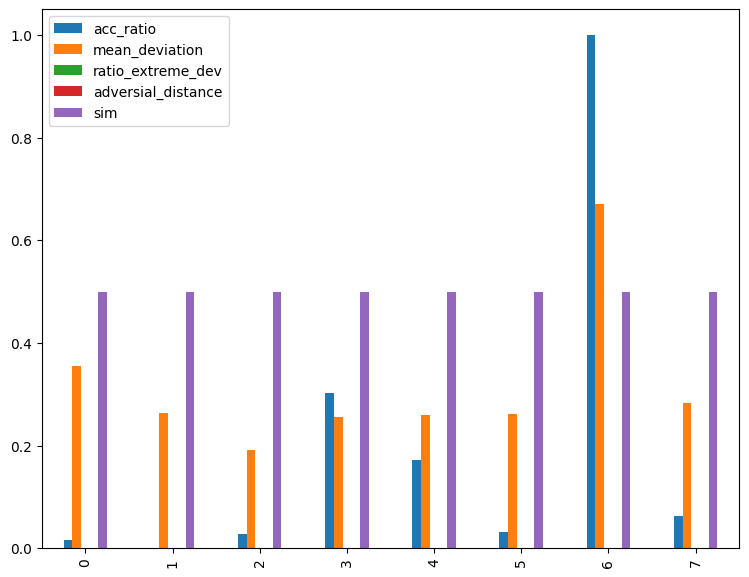

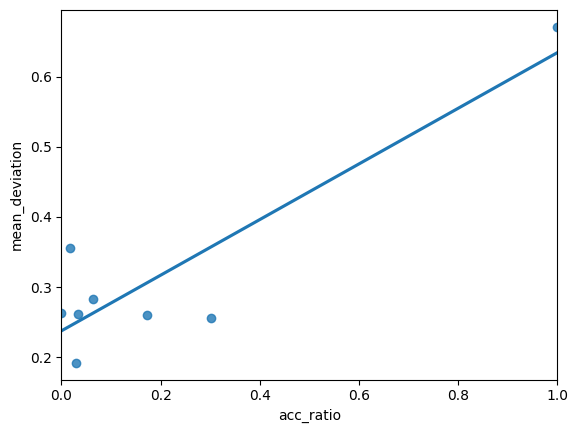

TOTAL ACC 0.8884225437089307


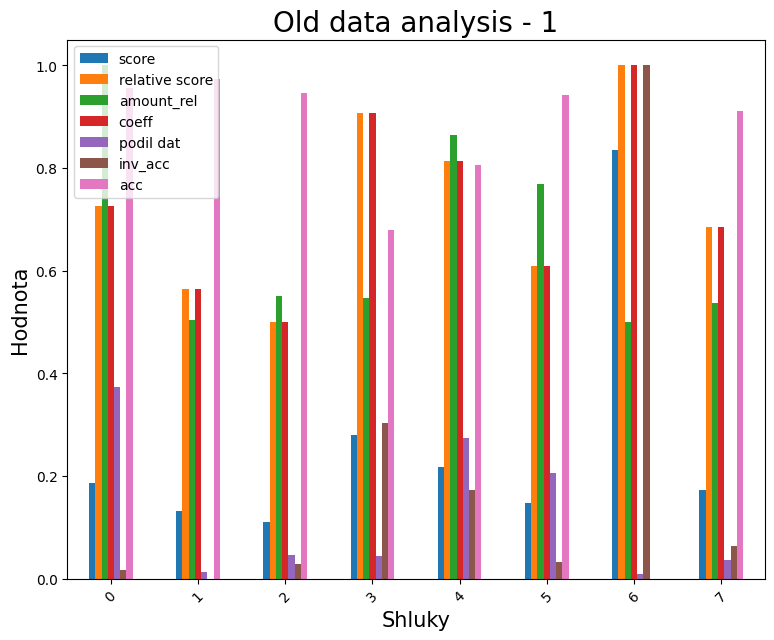

POTENTIAL AMOUNT 165177
REDUCED AMOUNT 15812
Extracted data 1  -  15812
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans Model Build progress: |████████████Parse progress: |███████████████████████████████████████████████████████████████████████████████| (done) 100%█
██████kmeans prediction progress: |██████████████████████████████████████████████████████████| (done) 100%█
██████████| (done) 100%
kmeans Model Build progress: |██████Parse progress: |███████████████████████████████████████████████████████████████████████| (done) 100%
███kmeans Model Build progress: |███████████████████████████████████████████████

/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


███████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


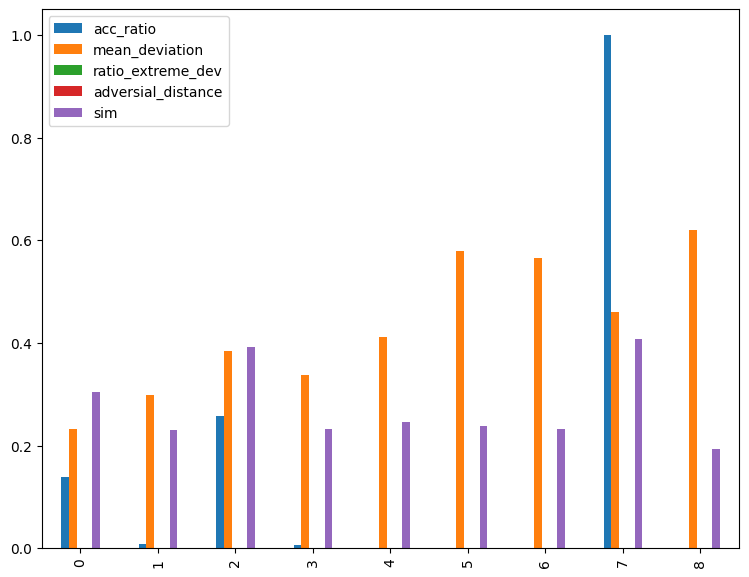

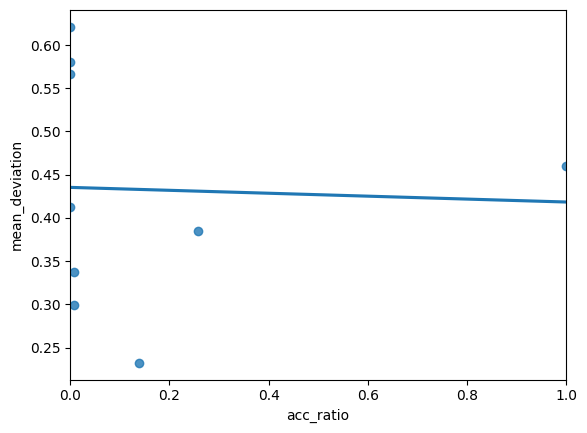

TOTAL ACC 0.9403048363655485


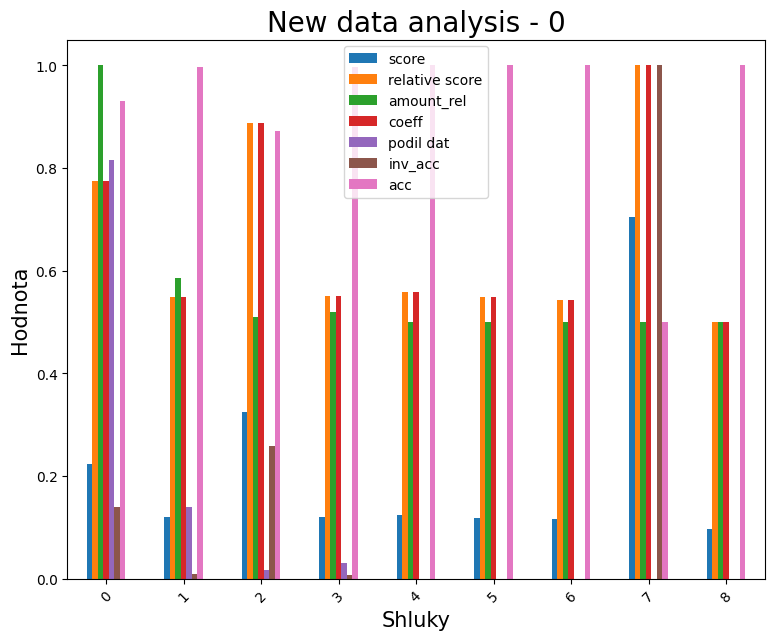

POTENTIAL AMOUNT 660085
REDUCED AMOUNT 15812
Extracted data 0  -  15813


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


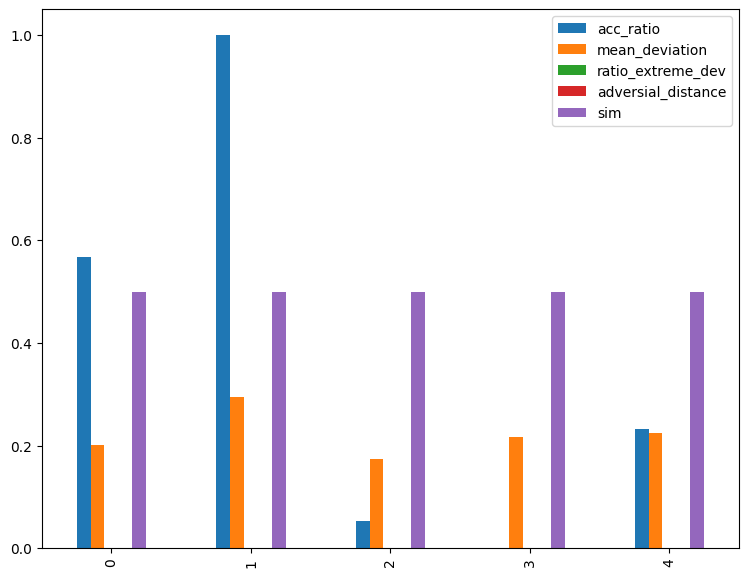

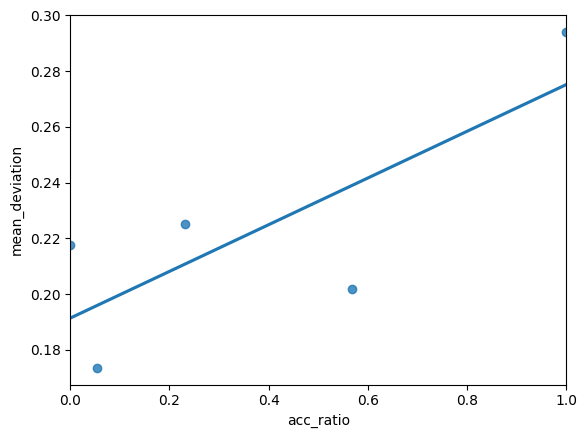

TOTAL ACC 0.986717602854477


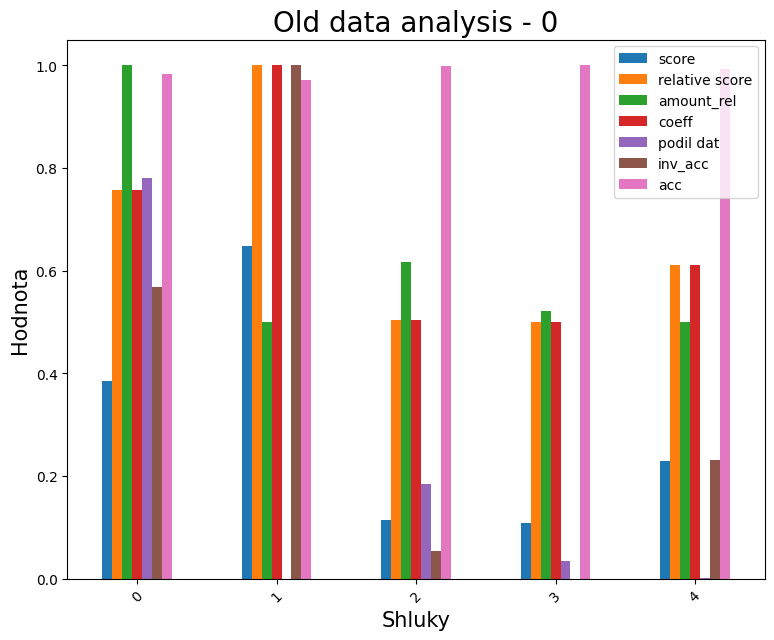

POTENTIAL AMOUNT 948140
REDUCED AMOUNT 63250
Extracted data 0  -  63250


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


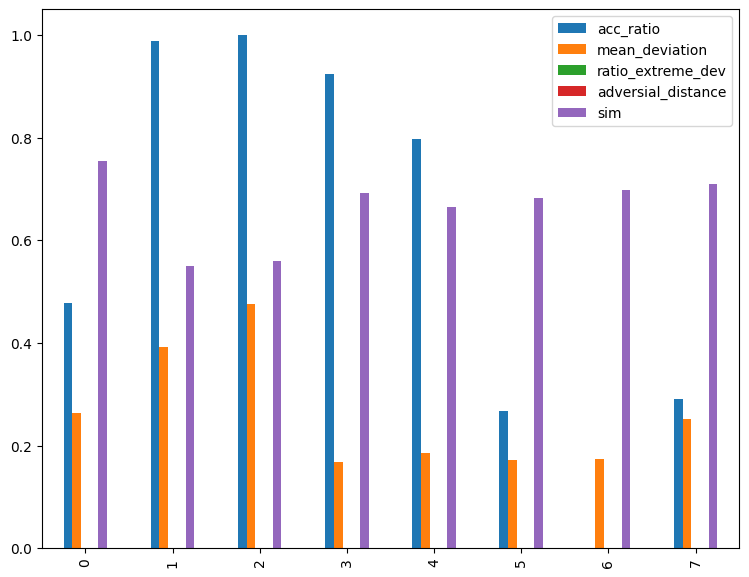

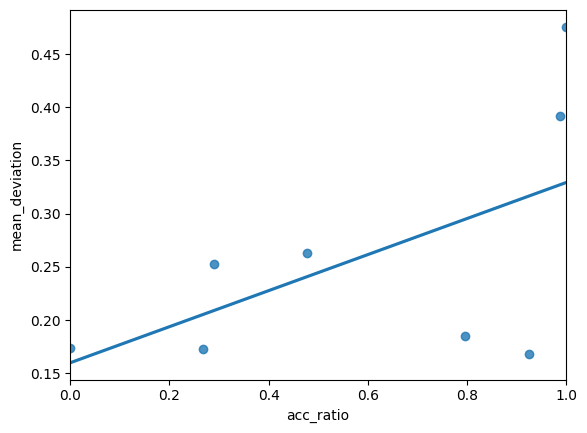

TOTAL ACC 0.2312909365631701


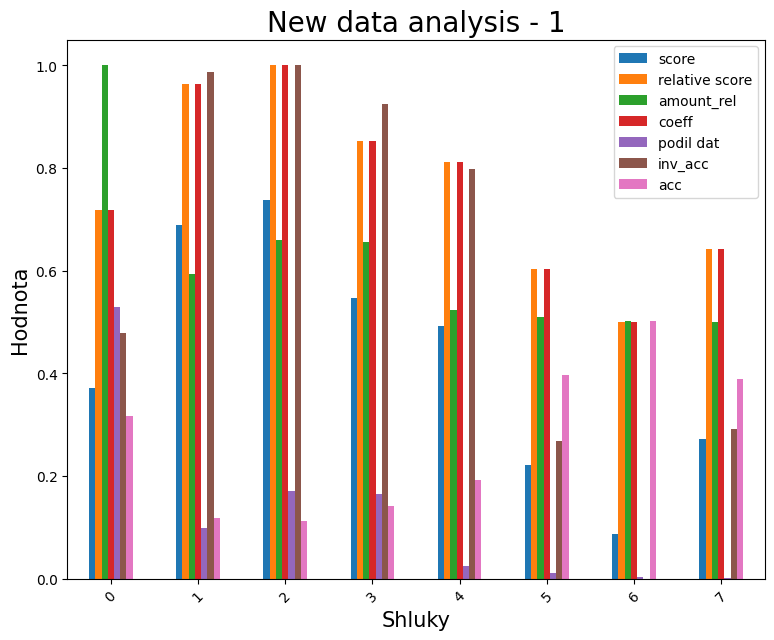

POTENTIAL AMOUNT 944458
REDUCED AMOUNT 63250
Extracted data 1  -  63250
CPU times: user 1.25 s, sys: 2.01 s, total: 3.26 s
Wall time: 3min 13s
Old dataset balance {0: 1352542, 1: 228729, 'all': 1581271}


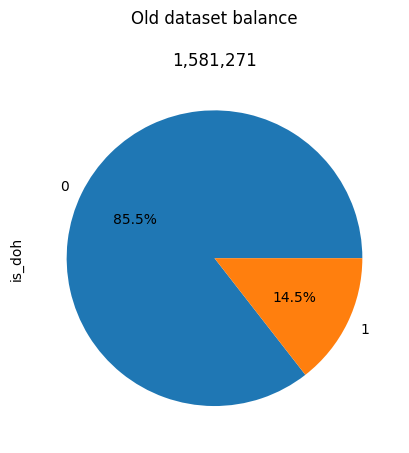

Clustered dataset balance {0: 79063, 1: 79062, 'all': 158125}


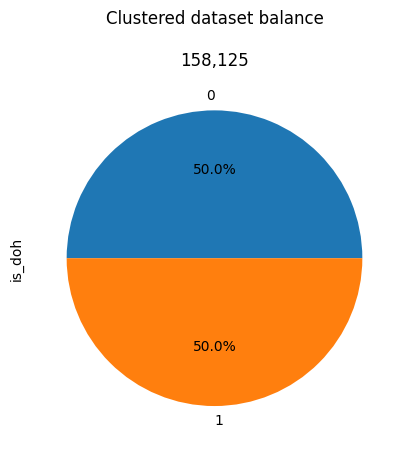

Reduction ratio 90.00013280456038


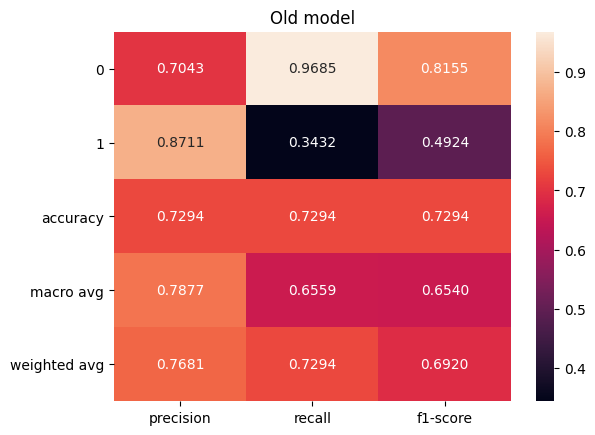

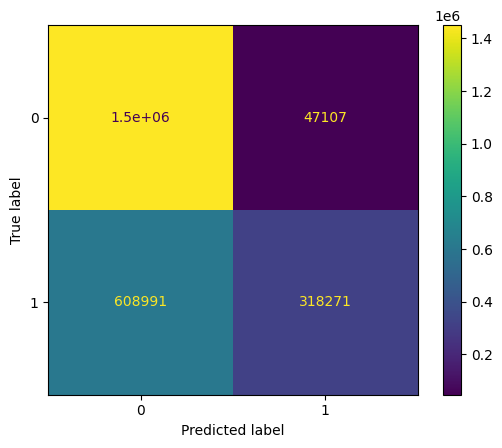

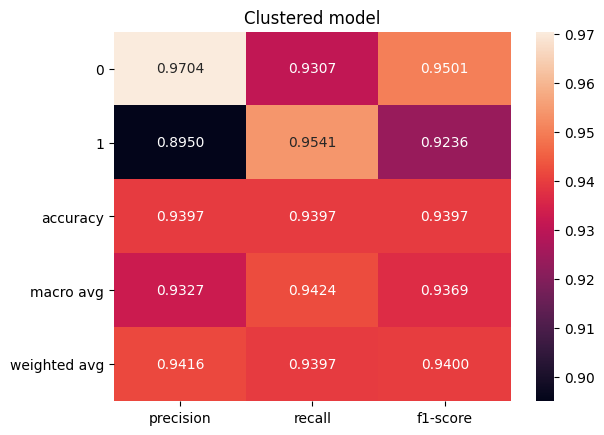

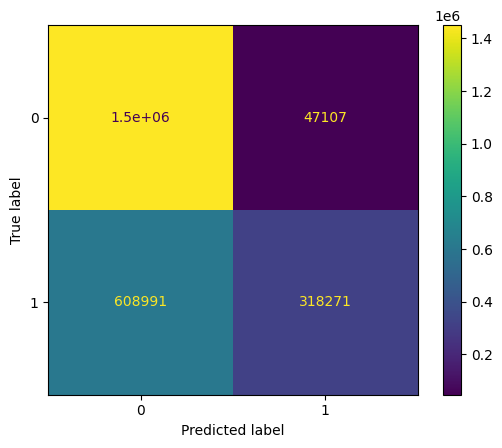

Improvement 80.51793277467563


In [132]:
# reduce all classes
def modification(label,metric='elbow',alg="kmeans"):
    
    # class reduction
    if alg=="h2o":
        cluster_model_old=H2O_model(old_data,clf_dumb,label)
        cluster_model_new=H2O_model(new_data,clf_old,label,strict=False)
    else:
        cluster_model_old=Sklearn_model(old_data,clf_dumb,label,model=alg,index=metric)
        cluster_model_new=Sklearn_model(new_data,clf_old,label,model=alg,index=metric,strict=False)

    #print(label,"old data analysis")
    delayed_fcs=[delayed(cluster_model_old.cluster_analysis)(pca=True,description="Old data analysis - "+str(label)),
                delayed(cluster_model_new.cluster_analysis)(pca=True,description="New data analysis - "+str(label))]
    #cluster_model_old.cluster_analysis(pca=True,description="Old data analysis - "+str(label))

    #print(label,"new data analysis")
    #cluster_model_new.cluster_analysis(pca=True,description="New data analysis - "+str(label))
    Parallel(n_jobs=2)(delayed_fcs)
    reduce_coeff=min(max(math.floor((cluster_model_new.total_acc/cluster_model_old.total_acc)*10)/10,0.2),0.8)
    print(reduce_coeff)

    if label == 1:
        reduced_amount=int((1581271*0.1)/2)#263545
        #reduce_coeff=0.2#int(old_data.y.shape[0]*0.2)
        
    else:
        reduced_amount=int((1581271*0.1)/2)#1581271*0.1
        #reduce_coeff=0.8#int(old_data.y.shape[0]*0.8)
    
    print(label,"old data reduction")
    
    extracted,reduced_data=old_data.reduce_coeff(cluster_model_old,reduced_amount*reduce_coeff,oversample=False)
    
    print(label,"new data augument")
    _,augument_data=new_data.reduce_coeff(cluster_model_new,reduced_amount-extracted,oversample=True)#old_data.y.shape[0]-extracted
    return pd.concat([reduced_data,augument_data],axis=0)

def modification_one(label,data,clf,undersample,metric='elbow',alg="kmeans",desc=""):
    
    # class reduction
    if alg=="h2o":
        cluster_model=H2O_model(data,clf,label)
        
    else:
        cluster_model=Sklearn_model(data,clf,label,model=alg,index=metric)
   
    cluster_model.cluster_analysis(pca=True,description=desc+" - "+str(label))

    
    extracted_data=data.reduce_coeff(cluster_model,undersample,oversample=False)
    
    
    return pd.DataFrame(extracted_data)

def modification_syntetic(metric='elbow',labels=[0,1],alg="kmeans",reduction_style='avg'):
    balance_old=old_data.class_balance(old_data.csv_data[old_data.label])
    print(balance_old)
    for label in labels:
        # class reduction
        if alg=="h2o":
            cluster_model_old=H2O_model(old_data,clf_dumb,label)
            cluster_model_new=H2O_model(new_data,clf_old,label)
        else:
            cluster_model_old=Sklearn_model(old_data,clf_dumb,label,model=alg,index=metric)
            cluster_model_new=Sklearn_model(new_data,clf_old,label,model=alg,index=metric)

        print(label,"old data synthesis")
        cluster_model_old.cluster_analysis(pca=True)
        
        print(label,"new data synthesis")
        cluster_model_new.cluster_analysis(pca=True)
        
        if label == 1:
            demanded_clusters_old=[1]
            demanded_clusters_new=[1,5,6]
            
        else:
            demanded_clusters_old=[2,3]
            demanded_clusters_new=[1,5,6]

        old_data.extract_data(cluster_model_old,demanded_clusters_old)
        new_data.extract_data(cluster_model_new,demanded_clusters_new)
    
    print("OLD data synt",old_data.class_balance(old_data.newdata[old_data.label].reset_index(drop=True)))
    print("NEW data synt",old_data.class_balance(new_data.newdata[new_data.label].reset_index(drop=True)))
    new_data.newdata=new_data.newdata.sample(n=int(old_data.newdata.shape[0]*0.1),random_state=42)
    print("NEW data synt sampled",old_data.class_balance(new_data.newdata[new_data.label].reset_index(drop=True)))
    new_data.newdata=pd.concat([old_data.newdata,new_data.newdata])   
    print("NEW data synt joined",old_data.class_balance(new_data.newdata[new_data.label].reset_index(drop=True)))
    new_data.synt_data=new_data.newdata.copy()
    new_data.update_csv()
    old_data.set_newdata()
    
    modification(metric=metric,alg=alg,reduction_style=reduction_style)
    
    
reduction=0.1
label_weights=[0.5,0.5]
style=[('Old',old_data,clf_dumb),('New',new_data,clf_old)]
input_vector=[]
for dataset_type,data,clf in style:
    desc=dataset_type+" data analysis"
    for label in [0,1]:
        if len(style) == 1: # only one dataset
            dataset_weights={"Old":1}
        else:
            reduce_coeff=min(max(math.floor((new_data.total_acc[label]/old_data.total_acc[label])*10)/10,0.2),0.8)
            dataset_weights={"Old":reduce_coeff,"New":1-reduce_coeff}

        demanded_amount=int(old_data.csv_data.shape[0]*reduction*label_weights[label]*dataset_weights[dataset_type])#263545
        print(desc+" - "+str(label),"To be extracted - ",demanded_amount)
        input_vector.append((label,data,clf,demanded_amount,desc))
print(input_vector)
for alg in ['h2o']:#h2o,aglomerative
    print(alg)
    if alg== 'h2o':
        k_methods=['default']
    else:
        k_methods=['bouldin']#,'silhouette','elbow','bouldin','PRE']:
    for metric in k_methods:
        print(metric)
        
        
        %time results=Parallel(n_jobs=4,backend="multiprocessing")([delayed(modification_one)(label=i[0],data=i[1],clf=i[2],undersample=i[3],metric=metric,alg=alg,desc=i[4]) for i in input_vector])
        
        
        old_data.newdata=pd.concat(results)
        #print(old_data.newdata)

        clf_reduced=AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',max_features=None),n_estimators=5,algorithm='SAMME.R'
            )
        clustered_result=old_data.compare_models(clf_old,clf_reduced,test_data)
        tmp=old_data.prepare_model_result(clustered_result,text,use_case,alg+'_'+metric)
        framework_result=pd.concat([framework_result,tmp])

        balance=old_data.class_balance(old_data.newdata[old_data.label].reset_index(drop=True))
        sampling_ratio=balance[1]/balance[0]
        balance_dict={0:balance[0],1:balance[1]}
        # old_data.set_data(pd.concat([X_train_old,y_train_old],axis=1))
        # old_data.set_newdata()
        # new_data.set_data(pd.concat([X_train_new,y_train_new],axis=1))
        # new_data.set_newdata()


In [36]:
framework_result

,Dataset,Method,Metric,Acc,Precision,Recall,F1,Impr,Support_0,Support_1
0,DOH,testing real 0.4_avg,h2o_default,0.939648,0.941552,0.939648,0.939983,80.514609,79063,79062
0,DOH,testing real 0.4_avg,h2o_default,0.925969,0.929111,0.925969,0.926488,76.133440,79063,79064
0,DOH,testing real 0.4_avg,h2o_default,0.900161,0.912079,0.900161,0.901371,67.978706,79062,79063
0,DOH,testing real 0.4_avg,h2o_default,0.923724,0.927043,0.923724,0.924272,75.413968,79063,79063
0,DOH,testing real 0.4_avg,h2o_default,0.939675,0.941576,0.939675,0.940010,80.523326,79063,79062
0,DOH,testing real 0.4_avg,h2o_default,0.939669,0.941570,0.939669,0.940003,80.521204,79063,79062
0,DOH,testing real 0.4_avg,h2o_default,0.939663,0.941565,0.939663,0.939998,80.519463,79063,79062
0,DOH,testing real 0.4_avg,h2o_default,0.939657,0.941560,0.939657,0.939991,80.517406,79063,79062


In [69]:
framework_result[-2:].to_csv(f"xsetin00/{use_case}_aging_comparation.csv",mode='a',index=False)

### Sampled union data

In [156]:
for label in [(0,225424),(1,38121)]:
    old_data.set_class(label[0])
    reduced_X_train_old, reduced_size, reduced_y_train_old, _ = train_test_split(old_data.X, old_data.y, train_size=label[1]*0.9/old_data.y.shape[0], random_state=42, shuffle=True)#, stratify=y_train_old)
    print(reduced_size.shape)
    new_data.set_class(label[0])
    reduced_X_train_new, reduced_size, reduced_y_train_new, _ = train_test_split(new_data.get_features(new_data.synt_data), new_data.get_label(new_data.synt_data), train_size=label[1]*0.1/new_data.get_label(new_data.synt_data).shape[0], random_state=42, shuffle=True)
    print(reduced_X_train_new.shape)
    if label[0]==0:
        X_train_union=pd.concat([reduced_X_train_old,reduced_X_train_new])
        y_train_union=pd.concat([reduced_y_train_old,reduced_y_train_new])
    else:
        X_train_union=pd.concat([X_train_union,reduced_X_train_old,reduced_X_train_new])
        y_train_union=pd.concat([y_train_union,reduced_y_train_old,reduced_y_train_new])
# size_ratio=X_train_old.shape[0]/X_train_union.shape[0]
# union_X_train, _, union_y_train, _ = train_test_split(X_train_union, y_train_union, train_size=size_ratio, random_state=42, shuffle=True, stratify=y_train_union)

print(old_data.class_balance(y_train_union))

(22543, 24)
(22542, 24)
(3813, 24)
(3812, 24)
{0: 225423, 1: 38120, 'all': 263543}


#### join and then sample

In [123]:
#206140 36494
for label in [(0,79063),(1,79062)]:
    old_data.set_class(label[0])
    new_data.set_class(label[0])
    if label[0]==0:
        X_train_union=pd.concat([old_data.X,new_data.X])#get_features(new_data.synt_data)
        y_train_union=pd.concat([old_data.y,new_data.y])#new_data.get_label(new_data.synt_data)
        X_train_union, reduced_size, y_train_union, _ = train_test_split(X_train_union, y_train_union, train_size=label[1]/y_train_union.shape[0], random_state=42, shuffle=True)
    else:
        X_train_union_tmp=pd.concat([old_data.X,new_data.X])
        y_train_union_tmp=pd.concat([old_data.y,new_data.y])
        reduced_X_train_old, reduced_size, reduced_y_train_old, _ = train_test_split(X_train_union_tmp,y_train_union_tmp, train_size=label[1]/y_train_union_tmp.shape[0], random_state=42, shuffle=True)
        X_train_union=pd.concat([X_train_union,reduced_X_train_old])
        y_train_union=pd.concat([y_train_union,reduced_y_train_old])
   

print(old_data.class_balance(y_train_union))

{0: 79063, 1: 79062, 'all': 158125}


In [ ]:
new_data.get_features(new_data.synt_data).shape

In [21]:
X_train_union=pd.concat([X_train_old,X_train_new])
y_train_union=pd.concat([y_train_old,y_train_new])
size_ratio=X_train_old.shape[0]/X_train_union.shape[0]
X_train_union, _, y_train_union, _ = train_test_split(X_train_union, y_train_union, train_size=size_ratio, random_state=42, shuffle=True, stratify=y_train_union)
print(old_data.class_balance(y_train_union))

{0: 162764, 1: 100781, 'all': 263545}


In [124]:
clf_union=AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',random_state=42,max_features=None),n_estimators=5,algorithm='SAMME.R',random_state=42
    )
clf_union.fit(X_train_union, y_train_union)
#pred=clf_union.predict(X_test)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=6,
                                                         random_state=42),
                   n_estimators=5, random_state=42)

In [125]:
old_data.cnt_new=old_data.class_balance(y_train_union)
pred_old = clf_old.predict(X_test)
pred_new = clf_union.predict(X_test)
f1_old=metrics.f1_score(y_test,pred_old,average="weighted")
f1_new=metrics.f1_score(y_test,pred_new,average="weighted")
space_to_improve=1-f1_old
old_data.improvement=(f1_new-f1_old)/space_to_improve*100

report=classification_report(y_test,pred_new,digits=4,output_dict=True)
tmp=old_data.prepare_model_result(report,text+'_'+'union_small',use_case)
framework_result=pd.concat([framework_result,tmp])

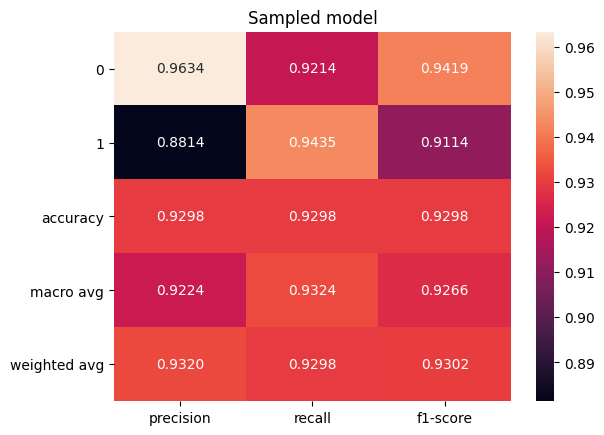

In [126]:
pred_new = clf_union.predict(X_test)

report=pd.DataFrame(classification_report(y_test,pred_new,digits=4,output_dict=True))
old_data.plot_report(report,"Sampled")


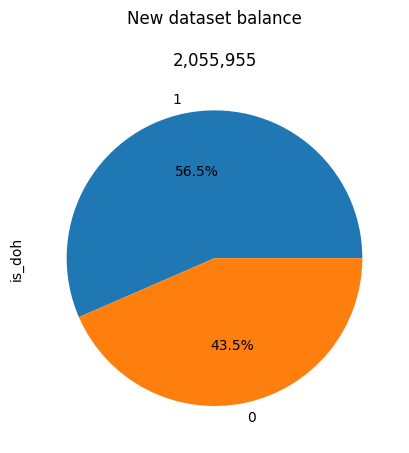

In [110]:
old_data.plot_balance("New model",new_data.get_all_label())

In [65]:
framework_result

,Dataset,Method,Metric,Acc,Precision,Recall,F1,Impr,Support_0,Support_1
0,DOH,testing real data big 0.4_avg,h2o_default,0.931071,0.932693,0.931071,0.931411,77.731834,922407,922408
0,DOH,testing real data big 0.4_avg,h2o_default,0.928684,0.931475,0.928684,0.929157,76.999940,790635,790635
0,DOH,testing real data big 0.4_union_small,default,0.930136,0.932930,0.930136,0.930601,77.468782,790635,790635
0,DOH,testing real data big 0.4_avg,h2o_default,0.932710,0.935126,0.932710,0.933127,78.288765,790634,790635
0,DOH,testing real data big 0.4_avg,h2o_default,0.932713,0.935129,0.932713,0.933130,78.289698,790634,790635
0,DOH,testing real data big 0.4_union_small,default,0.930136,0.932930,0.930136,0.930601,77.468782,790635,790634
0,DOH,testing real data big 0.4 reduced_avg,h2o_default,0.928620,0.931987,0.928620,0.929141,76.994683,118595,118594
0,DOH,testing real data big 0.4 reduced_union_small,default,0.924249,0.927103,0.924249,0.924752,75.569913,118595,118593


# Dataset reduction

DOH
{0: 1489653, 1: 1936940, 'all': 3426593}

h2o
default
avg
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,5 hours 59 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,"14 days, 7 hours and 26 minutes"
H2O_cluster_name:,H2O_from_python_netmon_j1ig59
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,28.69 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 65173.87574560357
Total Sum of Square Error to Grand Mean: 163856.0011673578
Between Cluster Sum of Square Error: 98682.12542175424

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           1512    12347.9
    2           3064    13139.7
    3           222     2568.69
    4           1       2.47126e-12
    5           1       5.14469e-12
    6           809     6358.76
    7           5       334.03
    8           105     3783.95
    9           1421    13079.2
    10          308     13561.7


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 0.7969924812030076
amount ratio 0.20300751879699247
inv_amount ratio 0.5886143931256713
amount ratio 0.4113856068743287
inv_amount ratio 0.9701933404940923
amount ratio 0.029806659505907628
inv_amount ratio 0.9998657357679914
amount ratio 0.0001342642320085929
inv_amount ratio 0.9998657357679914
amount ratio 0.0001342642320085929
inv_amount ratio 0.8913802363050484
amount ratio 0.10861976369495166
inv_amount ratio 0.999328678839957
amount ratio 0.0006713211600429646
inv_amount ratio 0.9859022556390977
amount ratio 0.014097744360902255
inv_amount ratio 0.8092105263157895
amount ratio 0.19078947368421054
inv_amount ratio 0.9586466165413534
amount ratio 0.041353383458646614


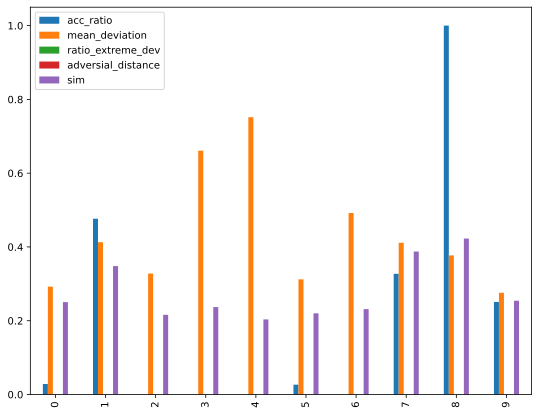

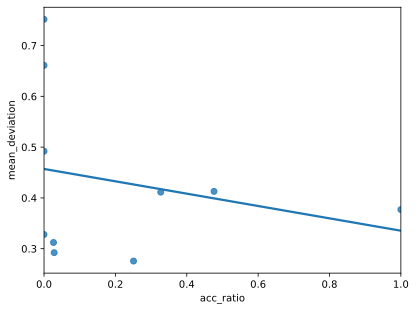

/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


APPLY 2SIGMA
0.911571581380747
AUG THRESHOLD 0.3998166641250083
RED THRESHOLD 0.3075904045828858
TOTAL ACC 0.9044038668098818


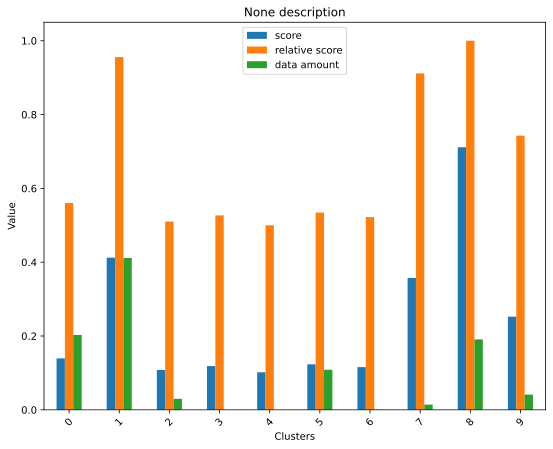

DEMAND 512.9
RATIO 0.6051293919813477
DEMAND lower  0
RATIO 0.1751392027253208
DEMAND lower  1
RATIO 4.530750161495499
DEMAND bigger  2
RATIO 973.4833580787094
DEMAND bigger  3
RATIO 1025.8
DEMAND bigger  4
RATIO 1.1859457338173767
DEMAND bigger  5
RATIO 196.39839040931855
DEMAND bigger  6
RATIO 5.35861582846079
DEMAND bigger  7
RATIO 0.3609429978888107
DEMAND lower  8
RATIO 2.2420594863009953
DEMAND bigger  9
DEFICIT 2716.4976405658144
REMAINDER 905.4992135219381
POTENTIAL AMOUNT 6070
REDUCED AMOUNT 5129


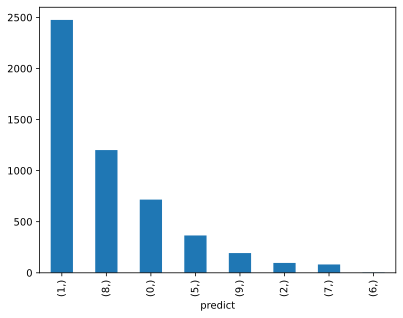

new data sampled 0
(5129, 25)
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,5 hours 59 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,"14 days, 7 hours and 26 minutes"
H2O_cluster_name:,H2O_from_python_netmon_j1ig59
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,28.69 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 105565.68357028384
Total Sum of Square Error to Grand Mean: 213048.0001491335
Between Cluster Sum of Square Error: 107482.31657884966

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           5166    48826.4
    2           1092    14105.8
    3           130     7892.77
    4           13      3415.32
    5           1861    18076.7
    6           1400    10621.4
    7           22      2627.28


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 0.46654275092936803
amount ratio 0.533457249070632
inv_amount ratio 0.8872366790582404
amount ratio 0.1127633209417596
inv_amount ratio 0.986575795125981
amount ratio 0.013424204874019
inv_amount ratio 0.9986575795125981
amount ratio 0.0013424204874019
inv_amount ratio 0.8078273440726973
amount ratio 0.19217265592730276
inv_amount ratio 0.8554316398182569
amount ratio 0.14456836018174307
inv_amount ratio 0.9977282114828583
amount ratio 0.002271788517141677


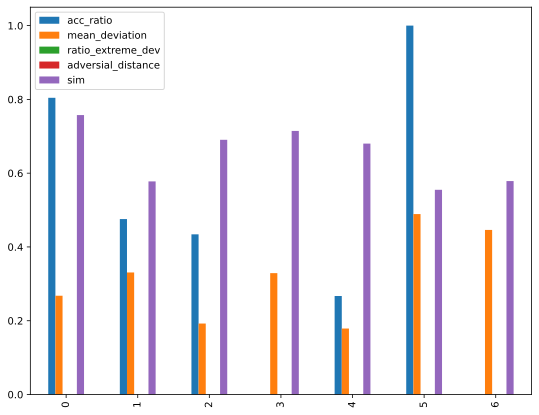

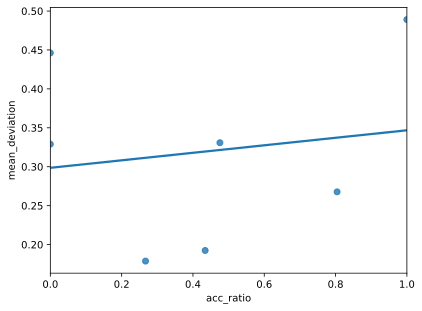

/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


1.0
AUG THRESHOLD 0.4965086845369348
RED THRESHOLD 0.4032572136661356
TOTAL ACC 0.9393845518380834


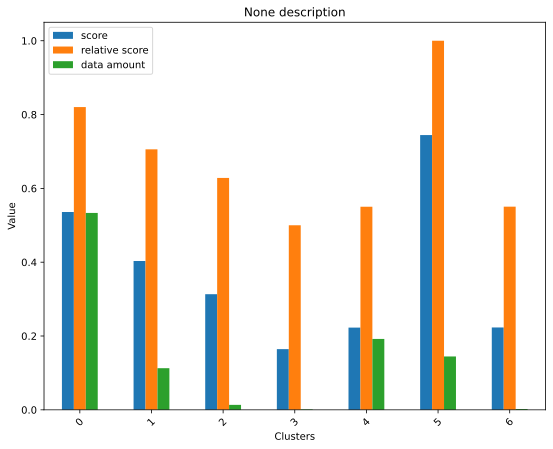

DEMAND 843.0
RATIO 0.19894235538337363
DEMAND lower  0
RATIO 1.0937996825678642
DEMAND bigger  1
RATIO 10.321071199259
DEMAND bigger  2
RATIO 129.69230769230768
DEMAND bigger  3
RATIO 0.8231532896658272
DEMAND lower  4
RATIO 0.6021428571428571
DEMAND lower  5
RATIO 69.60588781192187
DEMAND bigger  6
DEFICIT 2501.003538594032
REMAINDER 833.6678461980106
POTENTIAL AMOUNT 7532
REDUCED AMOUNT 5901


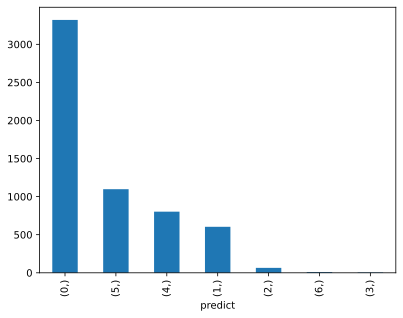

new data sampled 1
(5901, 25)
Old dataset balance {0: 7448, 1: 9684, 'all': 17132}


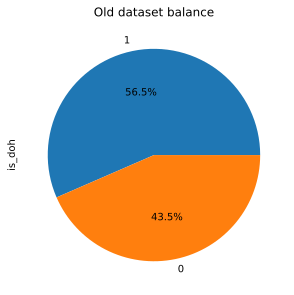

New dataset balance {0: 5129, 1: 5901, 'all': 11030}


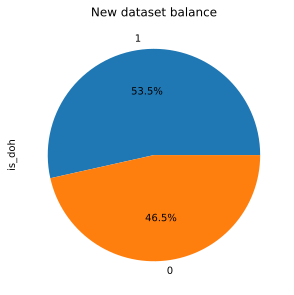

Reduction ratio 35.61755778659817
              precision    recall  f1-score   support

           0     0.9278    0.9237    0.9258   1482205
           1     0.9415    0.9447    0.9431   1927256

    accuracy                         0.9356   3409461
   macro avg     0.9347    0.9342    0.9345   3409461
weighted avg     0.9356    0.9356    0.9356   3409461



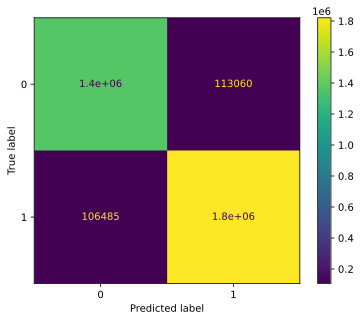

              precision    recall  f1-score   support

           0     0.9146    0.9276    0.9211   1482205
           1     0.9437    0.9334    0.9385   1927256

    accuracy                         0.9309   3409461
   macro avg     0.9292    0.9305    0.9298   3409461
weighted avg     0.9311    0.9309    0.9309   3409461



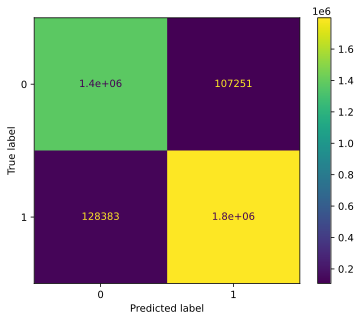

Improvement -7.216450376155979


In [222]:
use_case="DOH"
label="is_doh"
class_values=(True,False)
framework_result=pd.DataFrame()
filename="xsetin00/doh_test_analyze_3M.csv"#"doh_train_old+new.csv"

train_data=Modifier(f"{filename}",label,use_case,class_values)
train_data.load()
print(use_case)
print(train_data.class_balance(train_data.csv_data[label]))
#print(train_data.csv_data)
print()
clf=DecisionTreeClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(train_data.get_all_features(), train_data.get_all_label(), test_size=0.995, random_state=42, shuffle=True, stratify=train_data.get_all_label())
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
original_result=classification_report(y_test,pred,digits=4,output_dict=True)
train_data.cnt_new=train_data.class_balance(y_train)
tmp=train_data.prepare_model_result(original_result,'original',use_case)
framework_result=pd.concat([framework_result,tmp])
# metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, pred)).plot()
# plt.show()
train_data.set_data(pd.concat([X_train,y_train],axis=1))
test_data=Dataset(_,label,use_case,class_values)
test_data.set_data(pd.concat([X_test,y_test],axis=1))

# just small sample to train classifier
dumb_X_train, _, dumb_y_train, _ = train_test_split(train_data.get_all_features(), train_data.get_all_label(), test_size=0.8, random_state=42, shuffle=True, stratify=train_data.get_all_label())
clf_dumb=DecisionTreeClassifier(random_state=42)
clf_dumb.fit(dumb_X_train, dumb_y_train)

# reduce all classes
def reduction(metric='elbow',labels=[0,1],alg="kmeans",reduction_style='avg'):
    for label in labels:
        # class reduction
        if alg=="h2o":
            cluster_model=H2O_model(train_data,clf_dumb,label)
        else:
            cluster_model=Sklearn_model(train_data,clf_dumb,label,model=alg,index=metric)

        cluster_model.cluster_analysis(pca=True)
        if label == 0:
            reduced_amount=5129
        else:
            reduced_amount=5901

        train_data.reduce_coeff(cluster_model,reduced_amount)

for alg in ['h2o']:#h2o
    print(alg)
    if alg== 'h2o':
        k_methods=['default']
    else:
        k_methods=['bouldin','elbow']#,'silhouette','elbow','bouldin','PRE']:
    for metric in k_methods:
        print(metric)
        for reduction_style in ['avg']:
            print(reduction_style)
            
            reduction(metric=metric,alg=alg, reduction_style=reduction_style)

            clf_new=DecisionTreeClassifier(random_state=42)
            clustered_result=train_data.compare_models(clf,clf_new,test_data)
            tmp=train_data.prepare_model_result(clustered_result,'clustering_'+reduction_style,use_case,alg+'_'+metric)
            framework_result=pd.concat([framework_result,tmp])

            balance=train_data.class_balance(train_data.newdata[train_data.label].reset_index(drop=True))
            sampling_ratio=balance[1]/balance[0]
            balance_dict={0:balance[0],1:balance[1]}
            train_data.set_data(pd.concat([X_train,y_train],axis=1))
            train_data.set_newdata()



In [69]:
balance_dict#={1:5901,0:5129}

{1: 5901, 0: 5129}

In [228]:
framework_result

,Dataset,Method,Metric,Acc,Precision,Recall,F1,Impr,Support_0,Support_1
0,DOH,original,default,0.935607,0.935581,0.935607,0.935590,0.00000,7448,9684
0,DOH,clustering_avg,h2o_default,0.930888,0.931069,0.930888,0.930942,-7.21645,5129,5901


In [83]:
framework_result

,Dataset,Method,Metric,Acc,Precision,Recall,F1,Impr,Support
0,DOH,original,default,0.935607,0.935581,0.935607,0.935590,0.000000,"9684,7448"
0,DOH,clustering_uniform,aglo,0.931675,0.931848,0.931675,0.931508,-6.338327,"9684,5556"


### IMBL 

In [113]:
imbl=[#(NearMiss(sampling_strategy=balance_dict,version=1),"near_miss1"),#
      #(NearMiss(sampling_strategy=balance_dict,version=2),"near_miss2"),
      #(NearMiss(sampling_strategy=balance_dict,version=3),"near_miss3"),
      #(CondensedNearestNeighbour(random_state=42,sampling_strategy='all',n_jobs=-1),"condensed_NN"),
      #(EditedNearestNeighbours(),"edited_NN"),
      #(RepeatedEditedNearestNeighbours(sampling_strategy='all',n_jobs=-1),"rep_edited__NN"),
      #(InstanceHardnessThreshold(sampling_strategy=balance_dict,random_state=42, estimator=LogisticRegression(solver='lbfgs', max_iter=200)),"inst_hard_tresh"),
      #(NeighbourhoodCleaningRule(sampling_strategy='all',n_jobs=-1),"neigh_clean_rule"),
      #(OneSidedSelection(sampling_strategy='all',n_jobs=-1,random_state=42),"one_sided_sel"),
      #(RandomUnderSampler(sampling_strategy=balance_dict,random_state=42),"random_sampler"),
      #(TomekLinks(sampling_strategy='all',n_jobs=-1),"tomek_links"),
      #(AllKNN(sampling_strategy='all',n_jobs=-1),"allKNN"),
      #(ClusterCentroids(sampling_strategy=balance_dict,random_state=42),"cluster_centroids"),
      #(ClusterCentroids(sampling_strategy=balance_dict,random_state=42,estimator=KMeans(n_clusters=cluster_model.size)),"cluster_centroids_est_k")
      ]
overall_result=framework_result
for sampler in imbl:
  print(sampler[1])
  train_data.apply_imbalanced_lib(sampler[0])
  imbl_result=train_data.compare_models(clf,clf_new,test_data)
  tmp=train_data.prepare_model_result(imbl_result,sampler[1],use_case)
  overall_result=pd.concat([overall_result,tmp])

overall_result.reset_index(inplace=True,drop=True)
print(overall_result)

  Dataset         Method               Metric       Acc  Precision    Recall  \
0     DOH       original              default  0.935607   0.935581  0.935607   
1     DOH  clusteringavg  aglomerativebouldin  0.933307   0.933265  0.933307   
2     DOH  clusteringuni  aglomerativebouldin  0.925132   0.925078  0.925132   
3     DOH  clusteringavg    aglomerativeelbow  0.931675   0.931848  0.931675   
4     DOH  clusteringuni    aglomerativeelbow  0.919565   0.922098  0.919565   

         F1       Impr    Support  
0  0.935590   0.000000  9684,7448  
1  0.933250  -3.634349  8503,5587  
2  0.925087 -16.307118  7321,3725  
3  0.931508  -6.338327  9684,5556  
4  0.918916 -25.888691  9684,3664  


In [227]:
overall_result.to_csv(f"{use_case}_comparation.csv",mode='a',index=False)

NameError: name 'overall_result' is not defined

# Adasyn data

diabetes.csv
({1: 268}, {0: 500}, 768)

(250, 8)
CRIT 0.0990625
SSE 1660.7357698028668


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SSE 1333.2058252322868
PRE 0.1972197808501822 2


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SSE 1108.8436295563995
PRE 0.16828774029456123 3


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SSE 969.5073811833315
PRE 0.1256590601767811 4
SSE 871.0884364408246
PRE 0.10151438416320438

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 5


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SSE 772.8856084126862
PRE 0.11273577276422672 6
SSE 702.9753820969485
PRE 0.09045352320547911 7
Final K parameter: 6
SSE 772.8856084126862


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


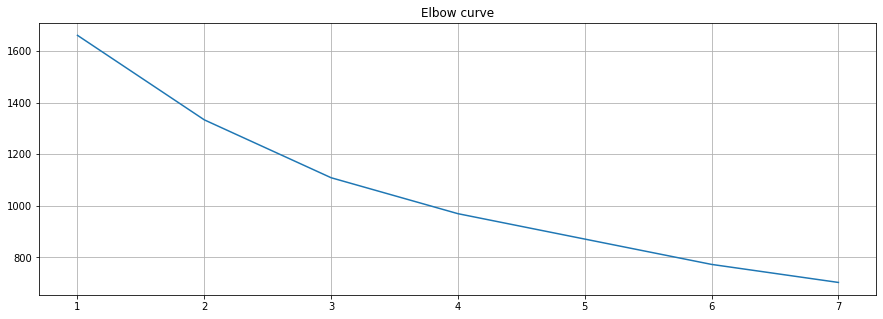

inv_amount ratio 70.4
amount ratio 29.599999999999998
inv_amount ratio 72.0
amount ratio 28.000000000000004
inv_amount ratio 86.8
amount ratio 13.200000000000001
inv_amount ratio 88.8
amount ratio 11.200000000000001
inv_amount ratio 85.6
amount ratio 14.399999999999999
inv_amount ratio 96.4
amount ratio 3.5999999999999996
AUG THRESHOLD 44.9687580588542
RED THRESHOLD 25.288888888888888


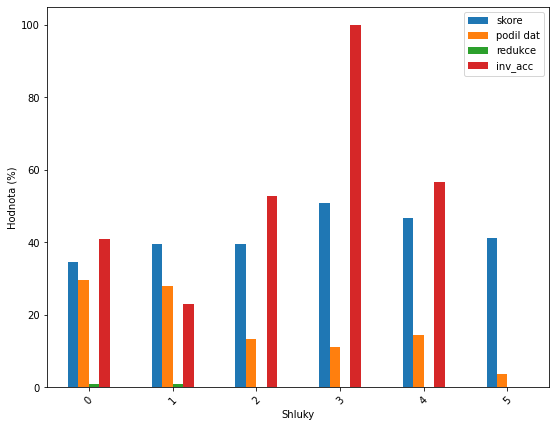

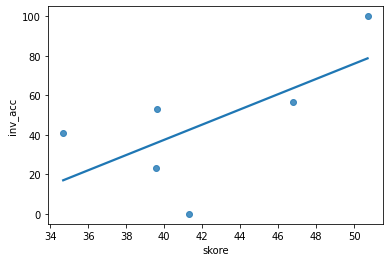

0    3
1    4
Name: augument, dtype: int64 --
 0    0
1    1
Name: reduction, dtype: int64
K ratio 16.666666666666668
Original ratio 29.599999999999998
New ratio 16.8
Reduction coef 0.5630630630630631
K ratio 16.666666666666668
Original ratio 28.000000000000004
New ratio 16.8
Reduction coef 0.5952380952380951
Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



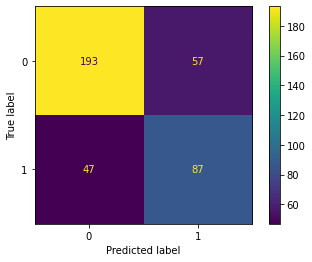

              precision    recall  f1-score   support

           0     0.7960    0.7960    0.7960       250
           1     0.6194    0.6194    0.6194       134

    accuracy                         0.7344       384
   macro avg     0.7077    0.7077    0.7077       384
weighted avg     0.7344    0.7344    0.7344       384



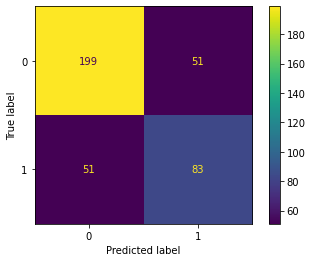

Improvement 1.153903066451125
near_miss1
Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



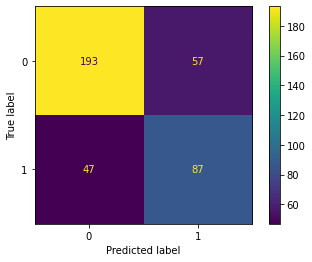

              precision    recall  f1-score   support

           0     0.7900    0.6920    0.7377       250
           1     0.5333    0.6567    0.5886       134

    accuracy                         0.6797       384
   macro avg     0.6616    0.6744    0.6632       384
weighted avg     0.7004    0.6797    0.6857       384



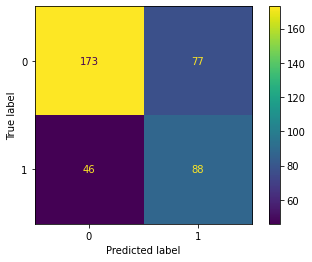

Improvement -16.957006170996923
near_miss2
Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



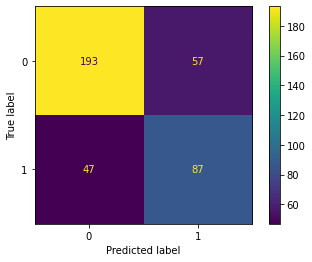

              precision    recall  f1-score   support

           0     0.7679    0.7280    0.7474       250
           1     0.5374    0.5896    0.5623       134

    accuracy                         0.6797       384
   macro avg     0.6527    0.6588    0.6549       384
weighted avg     0.6875    0.6797    0.6828       384



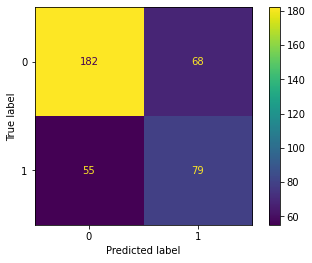

Improvement -18.030465331640237
random_sampler
Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



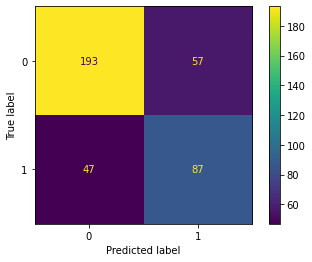

              precision    recall  f1-score   support

           0     0.7909    0.6960    0.7404       250
           1     0.5366    0.6567    0.5906       134

    accuracy                         0.6823       384
   macro avg     0.6637    0.6764    0.6655       384
weighted avg     0.7022    0.6823    0.6881       384



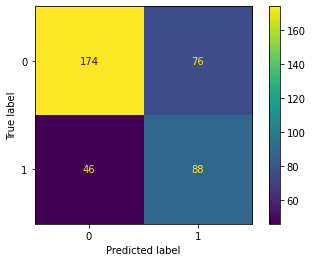

Improvement -16.0498505951066
cluster_centroids


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



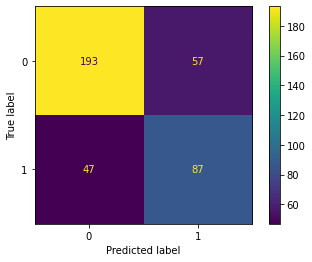

              precision    recall  f1-score   support

           0     0.8136    0.7160    0.7617       250
           1     0.5671    0.6940    0.6242       134

    accuracy                         0.7083       384
   macro avg     0.6904    0.7050    0.6929       384
weighted avg     0.7276    0.7083    0.7137       384



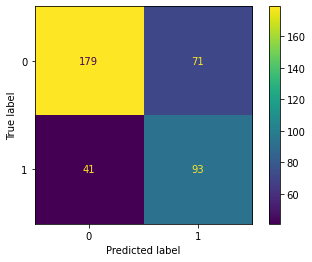

Improvement -6.537567759442138
cluster_centroids_est_k


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



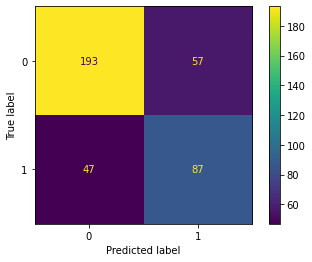

              precision    recall  f1-score   support

           0     0.7773    0.7400    0.7582       250
           1     0.5548    0.6045    0.5786       134

    accuracy                         0.6927       384
   macro avg     0.6661    0.6722    0.6684       384
weighted avg     0.6997    0.6927    0.6955       384



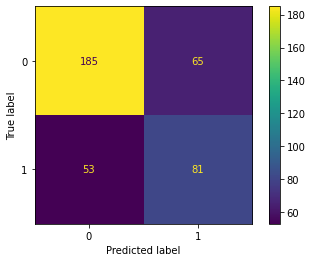

Improvement -13.306940035013392
    Dataset                   Method       Acc  Precision    Recall        F1  \
0  diabetes                 original  0.729167   0.734375  0.729167  0.731274   
1  diabetes               clustering  0.734375   0.734375  0.734375  0.734375   
2  diabetes               near_miss1  0.679688   0.700404  0.679688  0.685706   
3  diabetes               near_miss2  0.679688   0.687491  0.679688  0.682822   
4  diabetes           random_sampler  0.682292   0.702161  0.682292  0.688144   
5  diabetes        cluster_centroids  0.708333   0.727596  0.708333  0.713706   
6  diabetes  cluster_centroids_est_k  0.692708   0.699662  0.692708  0.695515   

        Impr  Support  
0   0.000000  134,250  
1   1.153903  134,190  
2 -16.957006  134,190  
3 -18.030465  134,190  
4 -16.049851  134,190  
5  -6.537568  134,190  
6 -13.306940  134,190  


In [ ]:
names=["diabetes.csv"]#,"abalone.csv","vowel.csv","ionosphere.csv","vehicle.csv"]

use_case="Adasyn"
label="Class"
class_values=(1,0)
overall_result=pd.DataFrame()
for name in names:
  train_data=Modifier(f"/content/drive/My Drive/Cluster/{use_case}/{name}",label,use_case,class_values)
  train_data.load()
  print(name)
  print(train_data.class_balance(train_data.csv_data[label]))
  #print(train_data.csv_data)
  print()
  clf=DecisionTreeClassifier(random_state=42)
  X_train, X_test, y_train, y_test = train_test_split(train_data.get_all_features(), train_data.get_all_label(), test_size=0.5, random_state=42, shuffle=True, stratify=train_data.get_all_label())
  clf.fit(X_train,y_train)
  pred = clf.predict(X_test)
  original_result=classification_report(y_test,pred,digits=4,output_dict=True)
  train_data.cnt_new=train_data.class_balance(y_train)
  tmp=train_data.prepare_model_result(original_result,'original',name[:-4])
  overall_result=pd.concat([overall_result,tmp])
  # metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, pred)).plot()
  # plt.show()
  train_data.set_data(pd.concat([X_train,y_train],axis=1))
  test_data=Dataset(_,label,use_case,class_values)
  test_data.set_data(pd.concat([X_test,y_test],axis=1))

  # just small sample to train classifier
  dumb_X_train, _, dumb_y_train, _ = train_test_split(train_data.get_all_features(), train_data.get_all_label(), test_size=0.8, random_state=42, shuffle=True, stratify=train_data.get_all_label())
  clf_dumb=DecisionTreeClassifier(random_state=42)
  clf_dumb.fit(dumb_X_train, dumb_y_train)

  cluster_model=Sklearn_model(train_data,clf_dumb,0)
  cluster_model.cluster_analysis(pca=True)
  train_data.reduce(cluster_model,1/cluster_model.size)
  train_data.set_class(1)
  minority_data=pd.concat([train_data.X,train_data.y],axis=1)
  train_data.newdata=pd.concat([train_data.newdata,minority_data])
  clf_new=DecisionTreeClassifier(random_state=42)
  clustered_result=train_data.compare_models(clf,clf_new,test_data)
  tmp=train_data.prepare_model_result(clustered_result,'clustering',name[:-4])
  overall_result=pd.concat([overall_result,tmp])

  balance=train_data.class_balance(train_data.newdata[train_data.label].reset_index(drop=True))
  sampling_ratio=balance[0][1]/balance[1][0]
  balance_dict={0:balance[1][0],1:balance[0][1]}
  imbl=[(NearMiss(sampling_strategy=balance_dict,version=1),"near_miss1"),#
        (NearMiss(sampling_strategy=sampling_ratio,version=2),"near_miss2"),
        #(NearMiss(sampling_strategy=sampling_ratio,version=3),"near_miss3"),
        # (CondensedNearestNeighbour(random_state=42),"condensed_NN"),
        # (EditedNearestNeighbours(),"edited_NN"),
        # (RepeatedEditedNearestNeighbours(),"rep_edited__NN"),
        # (InstanceHardnessThreshold(sampling_strategy=sampling_ratio,random_state=42),"inst_hard_tresh"),
        # (NeighbourhoodCleaningRule(),"neigh_clean_rule"),
        (RandomUnderSampler(sampling_strategy=sampling_ratio,random_state=42),"random_sampler"),
        # (TomekLinks(),"tomek_links"),
        (ClusterCentroids(sampling_strategy=sampling_ratio,random_state=42),"cluster_centroids"),
        (ClusterCentroids(sampling_strategy=sampling_ratio,random_state=42,estimator=KMeans(n_clusters=cluster_model.size)),"cluster_centroids_est_k")
        ]
  for sampler in imbl:
    print(sampler[1])
    train_data.apply_imbalanced_lib(sampler[0])
    imbl_result=train_data.compare_models(clf,clf_new,test_data)
    tmp=train_data.prepare_model_result(imbl_result,sampler[1],name[:-4])
    overall_result=pd.concat([overall_result,tmp])

overall_result.reset_index(inplace=True,drop=True)
print(overall_result)


In [ ]:
overall_result.to_csv(f"/content/drive/My Drive/Cluster/{use_case}/comparation.csv",index=False)

In [ ]:
overall_result

,Dataset,Method,Acc,Precision,Recall,F1,Impr,Support
0,diabetes,original,0.729167,0.734375,0.729167,0.731274,0.000000,"134,250"
1,diabetes,clustering,0.718750,0.726516,0.718750,0.721680,-3.570073,"134,226"
2,diabetes,near_miss1,0.731771,0.737518,0.731771,0.734042,1.029841,"134,226"
3,diabetes,near_miss2,0.687500,0.694536,0.687500,0.690354,-15.227397,"134,226"
4,diabetes,random_sampler,0.747396,0.751803,0.747396,0.749184,6.664874,"134,226"
5,diabetes,cluster_centroids,0.716146,0.732916,0.716146,0.721034,-3.810553,"134,226"
6,diabetes,cluster_centroids_est_k,0.729167,0.730125,0.729167,0.729626,-0.613359,"134,226"
7,abalone,original,0.926230,0.931065,0.926230,0.928527,0.000000,"21,344"
8,abalone,clustering,0.920765,0.922517,0.920765,0.921629,-9.652083,"21,300"
9,abalone,near_miss1,0.846995,0.916227,0.846995,0.876356,-72.994675,"21,299"


# DGA data

In [ ]:
dga_test_analyze="/content/drive/My Drive/Cluster/DGA/dga_test_analyze.csv"
label="class"
use_case="DGA"
class_values=("dga","legit")
class_number=1
drop=["domain"]
Data=Dataset(dga_test_analyze,label,use_case,class_values,drop)
Data.load()
print(Data.csv_data)

In [ ]:
classifier=load(f"/content/drive/My Drive/Cluster/DGA/is_dga_old.model")

old_data_path = f"/content/drive/My Drive/Cluster/{use_case}/dga_train_sampled.csv"
old_data=Modifier(old_data_path, label,use_case,class_values,drop)
old_data.load()

In [ ]:
pos_clustering_sklearn=Sklearn_model(Data,classifier,class_number)
pos_clustering_sklearn.cluster_analysis()

In [ ]:
neg_clustering_sklearn=Sklearn_model(Data,classifier,1-class_number)
neg_clustering_sklearn.cluster_analysis()

In [ ]:
old_data.reduce(pos_clustering_sklearn)
old_data.newdata

In [ ]:
old_data.reduce(neg_clustering_sklearn)
old_data.newdata

In [ ]:
pos_clustering_model=H2O_model(Data,classifier,class_number)
pos_clustering_model.cluster_analysis()

In [ ]:
old_data.reduce(pos_clustering_model)
old_data.newdata

In [ ]:
neg_clustering_model=H2O_model(Data,classifier,1-class_number)
neg_clustering_model.cluster_analysis()

In [ ]:
old_data.reduce(neg_clustering_model)
old_data.newdata

In [ ]:
classifier_new= DecisionTreeClassifier(criterion="entropy",random_state=42, max_depth=17)
#old_data.compare_models(classifier,classifier_new,Data)

In [ ]:
#sampler = RandomUnderSampler(sampling_strategy="all",random_state=42)
sampler = NearMiss(sampling_strategy="all",n_jobs=-1)  
old_data.apply_imbalanced_lib(sampler)
old_data.compare_models(classifier,classifier_new,Data)

In [ ]:
tmp=old_data.newdata

old_data.update_csv()

h2o.download_all_logs(dirname="/content/drive/My Drive/Cluster/log/", filename = 'autoh2o_log.zip')

# Old code

In [ ]:
#@title
# read input dataset for clustering 
#input= sys.argv[1]
sample_data = "/content/drive/My Drive/Cluster/sample_data.csv"
doh_paper= "/content/drive/My Drive/Cluster/doh_paper.csv"
new_data = "/content/drive/My Drive/Cluster/generated_data.csv"
real_data = "/content/drive/My Drive/Cluster/new_real.csv"
dga_data = "/content/drive/My Drive/Cluster/dga_only_test.csv"

dga_all_data = "/content/drive/My Drive/Cluster/3m_dga_1.48_reduced_features.csv"
doh_test_analyze="/content/drive/My Drive/Cluster/is_doh_test_analyze_3M.csv"
dga_test_analyze="/content/drive/My Drive/Cluster/dga_test_analyze.csv"

Data = pd.read_csv(dga_test_analyze)###
label="is_dga"
Data.rename(columns = {'class':label}, inplace = True)

flag=0
Data[label]=Data[label].apply(new_classes)

#Data[label]=1###!
#Data.rename(columns = {'class':'dga'}, inplace = True)
print(Data)
# filter data

label_data=Data[Data[label] == flag]

#final=Data.drop("domain")

# remove text column
#Data.pop('Dataset')
#Data.pop('domain') 
#Data.rename(columns={'metric_entropy':"met_ent"},inplace=True)

# convert to numpy and show data

y=label_data[label]
X=label_data.drop(columns=[label,"domain"]) ###is_doh
feature_cnt=X.shape[1]
sample_np=X.to_numpy()
X

In [ ]:
#@title
correlation_with_class=Data.drop(columns=[label]).corrwith(Data[label],method="spearman").reset_index()
correlation_with_class.columns=["atrr","corr"]
print(correlation_with_class)
corr_pos=correlation_with_class[correlation_with_class["corr"] >= 0.3]
corr_neg=correlation_with_class[correlation_with_class["corr"] <= -0.3]
#print(corr_pos)
#print(corr_neg)
atrr_correlation=pd.concat([corr_pos,corr_neg],axis=0).reset_index(drop=True)
print(atrr_correlation)
#atrr_correlation.to_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=False)

In [ ]:
#@title

class_corr=atrr_correlation ###is_doh
pos_corr=list(class_corr[class_corr["corr"]>0]["atrr"])
neg_corr=list(class_corr[class_corr["corr"]<0]["atrr"])
corr_pairs=list(itertools.product(pos_corr,neg_corr))+list(itertools.product(neg_corr,pos_corr))
corr_pairs

In [ ]:
#@title
h2o.init()
# create h2o data frame
sample = h2o.H2OFrame(sample_np)

Train model

In [ ]:
#@title
# model inicializaton
model=H2OKMeansEstimator(  k=10,
                                estimate_k=True,
                                standardize=True,
                                seed=1234,
                                max_iterations = 100)

# create model for kmeans algorithm
model.train(training_frame=sample)

# show some model metrics
print(model.model_performance())


Load or save existing model

---



---



In [ ]:
#@title
h2o.save_model(model=model, path="/content/drive/My Drive/Cluster/", force=True)
# model=h2o.load_model("/content/drive/My Drive/Cluster/kmeans_model")

In [ ]:
#@title
# apply kmeans to our dataset
result=model.predict(sample)
print(result)

In [ ]:
#@title
############################################################# show report on clustered dataset #############################################################

# number of created clusters
number_of_clusters=len(model.size())

# clustered data from h2o frame to pandas data frame
data_as_df = result.as_data_frame(use_pandas=True, header=True)

# init dictionary for individual clusters
clusters={}
report={}
for x in range(0,number_of_clusters):
    clusters['cluster{0}'.format(x)]=[]
    report['cluster{0}'.format(x)]={}

# insert clustered data to predicted cluster
for i,data in enumerate(sample_np):
    clusters['cluster{0}'.format(data_as_df.values[i][0])].append(data)


In [ ]:
#@title
# load model 
aclf_classifier_old=load("/content/drive/My Drive/Cluster/is_doh_new+old.model")
# train=pd.read_csv('/content/drive/My Drive/Cluster/is_doh_train_old+new.csv')
# y_old = train['is_doh']
# X_old = train.drop(columns=['is_doh'])

# aclf_classifier_old = AdaBoostClassifier(
#     base_estimator=DecisionTreeClassifier(
#         max_depth=6,
#         criterion='entropy',
#         max_features=None
#     ),
#     n_estimators=25,
#     algorithm='SAMME.R'
# )
# aclf_classifier_old.fit(X_old, y_old)

pred = aclf_classifier_old.predict(X)#Data.drop(columns=['is_doh']))
print(classification_report(y,pred))#Data["is_doh"], pred))
total_acc=metrics.accuracy_score(y,pred)
metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) ).plot();
total_acc

In [ ]:
#@title
classifier=load(f"/content/drive/My Drive/Cluster/{label}_old.model")

# train=pd.read_csv('/content/drive/My Drive/Cluster/dga_train_sampled.csv')
# train.rename(columns = {'class':label}, inplace = True)
# train[label]=train[label].apply(new_classes)

# y_old = train[label]
# X_old = train.drop(columns=[label,"domain"])
# classifier = DecisionTreeClassifier(criterion="entropy",random_state=42, max_depth=17)
# classifier.fit(X_old, y_old)

pred=classifier.predict(X)
print(classification_report(y,pred))#Data["is_doh"], pred))
total_acc=metrics.accuracy_score(y,pred)
metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) ).plot();
total_acc

In [ ]:
#@title
clf=classifier

In [ ]:
#@title
# save model

dump(clf, f"/content/drive/My Drive/Cluster/{label}_old.model")

In [ ]:
#@title
from pandas._libs.algos import diff_2d
s = pd.Series([flag])

# dataframe for heatmap
heatmap=pd.DataFrame()

for cluster in clusters:
    # number of cluster
    print(color.BOLD + color.RED+ cluster+ color.END)

    # dataframe for effective metrics computation
    df=pd.DataFrame(clusters[cluster],columns=X.columns)
    
    # classify cluster
    
    pred = clf.predict(df)
    y_gen = s.repeat(len(clusters[cluster]))
    print(classification_report(y_gen, pred))
    print(metrics.confusion_matrix(y_gen, pred))
    report[cluster]["acc"]=metrics.accuracy_score(y_gen,pred)
    #metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) ).plot();
    

    # variance of features
    print(color.BOLD +color.BLUE+'\nVariance of features:'+ color.END)
    print(df.var().sort_values().to_string())

    # average of features
    print(color.BOLD +color.BLUE+'\nAverage of features:'+ color.END)
    mean=df.mean()
    original_mean=X.mean()
    out=mean.sort_values()
    print(out.to_string())
    
    # average deviation of features
    diff=mean-original_mean
    # get maximal difference
    lower_min=abs(original_mean-X.min())
    lower_max=abs(original_mean-X.max())

    for i,value in diff.iteritems():
        if value < 0:
            diff.at[i]=value/lower_min[i]*100
        else:
            diff.at[i]=value/lower_max[i]*100

    print(color.BOLD +color.BLUE+'\nAverage deviation of features (%):'+ color.END)
    diff = diff.sort_values().dropna()
    out=diff
    print(out.to_string())
    report[cluster]["dev"]=out
    heatmap=pd.concat([heatmap,diff.rename(cluster)],axis=1)
    
    # correlation of features
    print(color.BOLD +color.BLUE+'\nCorrelation of features:'+ color.END)
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    out=df.corr(method='spearman').unstack().drop(labels=pairs_to_drop).sort_values().dropna()
    print(out.to_string())
    report[cluster]["corr"]=out

    # size of cluster
    print(color.BOLD + color.BLUE+'\nSize of cluster:'+ color.END)
    size=len(clusters[cluster])
    report[cluster]["size"]=size
    print(size,'\n')

Hard cluster score computation

In [ ]:
#@title
accs=list(map(lambda x: x[1]["acc"],list(report.items())))
max_acc=max(accs)
min_acc=min(accs)
accs

In [ ]:
#@title
#print(report['cluster0']["dev"])
acc_dev=[]
cluster_dev=[]
cluster_num=[]
chart=[]
amount=[]
red=[]
for cluster in report:
  
  dev=report[cluster]["dev"]
  corr=report[cluster]["corr"]
  
  # for later
  print(cluster)
  cnt=feature_cnt//3
  dev_neg=dev.head(cnt)
  dev_pos=dev.tail(cnt)
  dev_pos=dev_pos[lambda x: x<-50]
  dev_neg=dev_neg[lambda x: x>50]

  # amount of data in cluster
  amount_ratio=report[cluster]["size"]/X.shape[0]*100
  inv_amount_ratio=100-amount_ratio
  print("inv_amount ratio",inv_amount_ratio)


  # pick up most deviated clusters 
  extreme_deviation=dev[lambda x: (x < -50) | (x > 50)]
  if extreme_deviation.empty:
    mean_deviation=0
  else:
    abs_dev=extreme_deviation.abs()
    mean_deviation=abs_dev.mean()
  
  print("average deviation",mean_deviation)

  extreme_deviation_cnt=len(extreme_deviation)
  ratio_extreme_deviation=extreme_deviation_cnt/len(dev)*100
  
  print("ratio of extreme deviation",ratio_extreme_deviation)
  cluster_dev.append(extreme_deviation_cnt)
  
  

  # check if negativly correlated attrr are adversarial
  corr_pos=corr[lambda x: x >= 0.75]
  corr_neg=corr[lambda x: x <= -0.3]
  adversial_distance=0
  corr_cnt=0
  if not corr_neg.empty:
    #print(corr_neg)
    for corr in corr_neg.index:
      if corr in corr_pairs:
        corr_cnt+=1
        #print(corr)
        first = corr[0]
        second = corr[1]
        #print(first,second)
        adversial_distance+=abs(dev[first]-dev[second])
    if corr_cnt != 0:
      adversial_distance/=corr_cnt*2
      adversial_distance=100-adversial_distance
  
  print("adversarial distance",adversial_distance)
  
  #similarity to another class
  
  neg_attr=list(class_corr[class_corr["corr"]<0]["atrr"])
  pos_attr=list(class_corr[class_corr["corr"]>0]["atrr"])
  #print(neg_attr,pos_attr)
  sim_neg=0
  sim_pos=0

  for attr in neg_attr:
    sim_neg+=dev[attr]
  if len(neg_attr) != 0:
    sim_neg=(sim_neg/len(neg_attr)+100)/2
  
  
  for attr in pos_attr:
      sim_pos+=dev[attr]
  if len(pos_attr) != 0:
    sim_pos=(sim_pos/len(pos_attr)+100)/2
  

  if flag:
    sim_pos=100-sim_pos
  else:
    sim_neg=100-sim_neg
  sim=(sim_neg+sim_pos)/2
  print("similarity",sim)
  
  
  relative_deviation_acc=report[cluster]["acc"]-total_acc
 
  if relative_deviation_acc < 0:
      acc_ratio=((relative_deviation_acc/abs(min_acc-total_acc)*(-100))+100)/2
  else:
      acc_ratio=((relative_deviation_acc/abs(max_acc-total_acc)*(-100))+100)/2
  
  print("relative deviation of model acc",acc_ratio,relative_deviation_acc,total_acc,report[cluster]["acc"])
  acc_dev.append(acc_ratio)
  

  # make one metrics, always percenatge, complement of acc, maybe normalize to 0,1 by averaging
  cluster_metric=(mean_deviation+ratio_extreme_deviation+adversial_distance+inv_amount_ratio+sim+acc_ratio)/6
  

  # reduction candidate
  reduction_threshold=100/number_of_clusters*1.9
  if amount_ratio > reduction_threshold and cluster_metric < 60:
    report[cluster]['red']=1
    print("reduction candidate",amount_ratio,reduction_threshold)
  else:
    report[cluster]['red']=0
  
  print("FINAL",cluster_metric)
  #chart.append((cluster_metric,report[cluster]["acc"],report[cluster]["red"]))
  chart.append(cluster_metric)
  amount.append(amount_ratio)
  red.append(report[cluster]['red'])
  cluster_num.append(cluster)
print(chart)

score_data=pd.DataFrame({"skore":chart,"podil dat":amount,"redukce":red,"inv_acc":acc_dev})




In [ ]:
#@title
ax=score_data.plot.bar(figsize=(9,7))
ax.set(xlabel='Shluky', ylabel='Hodnota (%)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
fig=ax.get_figure()
plt.show()
plt.clf()
ax=sns.regplot(x="skore",y="inv_acc",data=score_data,ci=None)
# fig.savefig(f"/content/drive/My Drive/Cluster/score_chart_{label}_{flag}.pdf")

In [ ]:
#@title
temp=pd.Series(chart)
treshold=(2*temp.mean()+temp.max())/3
print(treshold)
print(reduction_threshold)

In [ ]:
#@title
print(acc_dev)
print(cluster_dev)
data_plot=pd.DataFrame({"acc":acc_dev,"dev":cluster_dev})
data_plot.sort_values("dev",inplace=True)
data_plot.drop_duplicates("dev",inplace=True)
print(data_plot)

plt.plot( 'dev', 'acc', data=data_plot, marker='o', color='mediumvioletred')
plt.show()
df=pd.DataFrame(chart,columns=["metric","acc","red"])
df.sort_values("metric",inplace=True)
print(df)

plt.plot( 'metric', 'acc', data=df, marker='o', color='mediumvioletred')

Save results

In [ ]:
#@title
output=score_data[score_data["skore"]>treshold].reset_index()["index"]
output=output.rename("augument")
reduction= score_data[score_data["redukce"]==1].reset_index()["index"]
reduction = reduction.rename("reduction")

output.to_csv(f'/content/drive/My Drive/Cluster/{label}_{flag}_result_2.0.txt',index=False)
reduction.to_csv(f'/content/drive/My Drive/Cluster/{label}_{flag}_result_2.0.txt',index=False,mode="a")

print(output,"--\n",reduction)


In [ ]:
#@title

data_enrichment=pd.read_csv(real_data)
doh_true=data_enrichment[data_enrichment["is_doh"]==True]
doh_true.pop("is_doh")
print(doh_true)

In [ ]:
#@title
converted=h2o.H2OFrame(doh_true)
clustered=model.predict(converted)
print(clustered)


In [ ]:
#@title
print(heatmap)
graph=sns.heatmap(heatmap,cmap="coolwarm", cbar_kws={"label":"[%]"})
graph.set(xlabel='Clusters', ylabel='Features')
graph.set_xticklabels(graph.get_xticklabels(), rotation=45)